# Setup Instructions
Run the following cell to set up the environment:
1. Clone this repository
2. Install dependencies
3. Run the notebook cells in order

In [54]:
!git clone https://github.com/farideh-tavakoli/hybrid-ml-machine-behavior.git
%cd hybrid-ml-machine-behavior
!pip install -r requirements.txt

Cloning into 'hybrid-ml-machine-behavior'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 44 (delta 14), reused 39 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 23.38 MiB | 21.92 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/Users/faridehtavakoli/Desktop/hybrid-ml-machine-behavior/hybrid-ml-machine-behavior/hybrid-ml-machine-behavior
  Obtaining dependency information for matplotlib==3.10.7 from https://files.pythonhosted.org/packages/45/a8/bfed45339160102bce21a44e38a358a1134a5f84c26166de03fb4a53208f/matplotlib-3.10.7-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Using cached matplotlib-3.10.7-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
ERROR: Ignored the following versions that require a different python version: 2.3.0 Requires-Python >=3.11; 2.3.1 Requires-Python >=3.11; 2.3.2 Requires-Python >=3.11; 2.3.3 Requires-Python >=3.11; 2.3.4 Requires-Pyth

In [98]:
import os
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.colors as mcolors

In [99]:
# Pandas display configuration
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# 1- Business Understandig
- The **objective** of this study is to uncover distinct behavioral patterns among industrial machines using clustering and classification techniques.  
- Machines with similar operational profiles are grouped into behavioral categories such as *highly productive*, *normal operation*, *idle–stable*, or *fault-prone*.  
- This segmentation enables early detection of underperforming machines and supports data-driven maintenance planning.

- Because each subtechnology type exhibits different functional characteristics and operational ranges, benchmarks are established separately within each subtechnology.  
- In this framework, clusters represent behavioral categories whose definitions emerge from data rather than predefined labels.  
- By identifying these data-driven patterns, the methodology provides a foundation for targeted performance monitoring and actionable maintenance recommendations.

# 2- Data Underasting:
Second step in CRISP-DM methodology is Data Understanding. The main goal of this step is to get familiar with the data, identify data quality issues, and discover initial insights. 

## 2-1- Collection
The dataset used in this study was compiled from multiple IoT data sources, including SQL Server Management Studio, a CRM database, and Azure Data Explorer. These sources were integrated in Power BI, where initial transformations and data cleaning were performed before exporting the unified dataset for analysis in Python.  

### 2-1-1- Data Privacy Note:
- To ensure data privacy, machine serial numbers and subtechnology identifiers were anonymized in compliance with GDPR regulations.

In [100]:
df = pd.read_csv('dataset/anonymized_data.csv')

## 2-2- Description
The dataset contains approximately 36,106 daily records, each representing the aggregated operational behavior of a single machine over one day.  

### 2-2-1- Attributes Information and Semantics

In [101]:
df.columns

Index(['Serial Number', 'Date', 'Subtechnology_Name_ITA', 'Shipment Date',
       'Manufacturing Date', 'EXE_TotalDuration', 'FAIL_TotalDuration',
       'POWER_OFF_TotalDuration', 'READY_TotalDuration', 'N_Change_EXE_READY',
       'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE',
       'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_EXE',
       'N_Change_FAIL_READY', 'N_Change_FAIL_POWER_OFF',
       'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY',
       'N_Change_POWER_OFF_FAIL'],
      dtype='object')

### Dataset description
1. `Serial Number`: Machine serial number (anonymized).
2. `Date`: Date of the record.
3. `Subtechnology_Name_ITA`: Name of the machine's subtechnology (anonymized).
4. `Shipment Date`: Date when the machine was shipped either to the customer or another distributor.
5. `Manufacturing Date`: Date when the machine was manufactured.
6. `EXE_TotalDuration`: Total execution duration of the machine on that Date.
7. `FAIL_TotalDuration`: Total failure duration of the machine on that Date.
8. `POWER_OFF_TotalDuration`: Total power-off duration of the machine on that Date.
9. `READY_TotalDuration`: Total ready duration of the machine on that Date.
10. `N_Change_EXE_READY`: Number of changes between execution and ready states on that date.
11. `N_Change_EXE_FAIL`: Number of changes between execution and failure states on that date.
12. `N_Change_EXE_POWER_OFF`: Number of changes between execution and power-off states on that date.
13. `N_Change_READY_EXE`: Number of changes between ready and execution states on that date.
14. `N_Change_READY_FAIL`: Number of changes between ready and failure states on that date.
15. `N_Change_READY_POWER_OFF`: Number of changes between ready and power-off states on that date.
16. `N_Change_FAIL_EXE`: Number of changes between failure and execution states on that date.
17. `N_Change_FAIL_READY`: Number of changes between failure and ready states on that date.
18. `N_Change_FAIL_POWER_OFF`: Number of changes between failure and power-off states on that date.
19. `N_Change_POWER_OFF_EXE`: Number of changes between power-off and execution states on that date.
20. `N_Change_POWER_OFF_READY`: Number of changes between power-off and ready states on that date.
21. `N_Change_POWER_OFF_FAIL`: Number of changes between power-off and failure states on that date.

**Note:**

- Duration attributes are in seconds.



### 2-2-2- Data Profiling
In this section, we perform data profiling to understand the structure, completeness, and quality of the dataset. This includes checking for missing values, data types, and basic statistics of numeric attributes.

In [102]:
# some statistics on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36106 entries, 0 to 36105
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Serial Number             36106 non-null  object
 1   Date                      36106 non-null  object
 2   Subtechnology_Name_ITA    36047 non-null  object
 3   Shipment Date             35451 non-null  object
 4   Manufacturing Date        36106 non-null  object
 5   EXE_TotalDuration         36106 non-null  int64 
 6   FAIL_TotalDuration        36106 non-null  int64 
 7   POWER_OFF_TotalDuration   36106 non-null  int64 
 8   READY_TotalDuration       36106 non-null  int64 
 9   N_Change_EXE_READY        36106 non-null  int64 
 10  N_Change_EXE_FAIL         36106 non-null  int64 
 11  N_Change_EXE_POWER_OFF    36106 non-null  int64 
 12  N_Change_READY_EXE        36106 non-null  int64 
 13  N_Change_READY_FAIL       36106 non-null  int64 
 14  N_Change_READY_POWER_O

In [103]:
# Descriptive statistics
df.describe()

EXE_TotalDuration  FAIL_TotalDuration  POWER_OFF_TotalDuration  \
count           36106.00            36106.00                 36106.00   
mean             8349.49             1342.47                  6179.85   
std              9350.82             4452.49                  9729.82   
min                 0.00                0.00                     0.00   
25%              1421.25                3.00                   134.00   
50%              5555.00               47.00                  1890.00   
75%             12151.00              371.00                  8227.00   
max             81372.00            72138.00                 86005.00   

       READY_TotalDuration  N_Change_EXE_READY  N_Change_EXE_FAIL  \
count             36106.00            36106.00           36106.00   
mean              14367.72               70.57               3.12   
std               10509.94              127.67              15.77   
min                   0.00                0.00               0.00   
25%                5331.00                9.00               0.00   
50%               13330.50               28.00               0.00   
75%               21842.75               70.00               1.00   
max               79160.00             2015.00             715.00   

       N_Change_EXE_POWER_OFF  N_Change_READY_EXE  N_Change_READY_FAIL  \
count                36106.00            36106.00             36106.00   
mean                     1.36               71.70                 2.65   
std                      5.81              128.15                 6.64   
min                      0.00                0.00                 0.00   
25%                      0.00                9.00                 0.00   
50%                      0.00               29.00                 1.00   
75%                      1.00               71.00                 3.00   
max                    352.00             2021.00               121.00   

       N_Change_READY_POWER_OFF  N_Change_FAIL_EXE  N_Change_FAIL_READY  \
count                  36106.00           36106.00             36106.00   
mean                       4.39               2.41                 3.65   
std                        7.19              14.62                 8.02   
min                        0.00               0.00                 0.00   
25%                        1.00               0.00                 0.00   
50%                        2.00               0.00                 1.00   
75%                        5.00               0.00                 4.00   
max                      226.00             709.00               161.00   

       N_Change_FAIL_POWER_OFF  N_Change_POWER_OFF_EXE  \
count                 36106.00                36106.00   
mean                      1.19                    0.92   
std                       3.82                    5.83   
min                       0.00                    0.00   
25%                       0.00                    0.00   
50%                       0.00                    0.00   
75%                       1.00                    0.00   
max                     174.00                  348.00   

       N_Change_POWER_OFF_READY  N_Change_POWER_OFF_FAIL  
count                  36106.00                 36106.00  
mean                       4.50                     1.48  
std                        7.04                     3.69  
min                        0.00                     0.00  
25%                        1.00                     0.00  
50%                        2.00                     1.00  
75%                        5.00                     1.00  
max                      189.00                   157.00

In [104]:
# print number of records
print(f"Number of records are: {df.shape[0]}")

Number of records are: 36106


In [105]:
df.head()

Serial Number                     Date Subtechnology_Name_ITA  \
0       MC_0001  2025-03-03 00:00:00.000                  sub_1   
1       MC_0001  2025-03-04 00:00:00.000                  sub_1   
2       MC_0001  2025-03-06 00:00:00.000                  sub_1   
3       MC_0001  2025-03-07 00:00:00.000                  sub_1   
4       MC_0001  2025-03-10 00:00:00.000                  sub_1   

             Shipment Date       Manufacturing Date  EXE_TotalDuration  \
0  2024-12-13 00:00:00.000  2024-09-23 00:00:00.000               3083   
1  2024-12-13 00:00:00.000  2024-09-23 00:00:00.000                  0   
2  2024-12-13 00:00:00.000  2024-09-23 00:00:00.000               8156   
3  2024-12-13 00:00:00.000  2024-09-23 00:00:00.000              11043   
4  2024-12-13 00:00:00.000  2024-09-23 00:00:00.000               1407   

   FAIL_TotalDuration  POWER_OFF_TotalDuration  READY_TotalDuration  \
0                 109                     7544                 7580   
1                 321                       22                 1012   
2                 468                     1827                 6214   
3                 137                     1643                 6204   
4                  20                     1299                 1533   

   N_Change_EXE_READY  N_Change_EXE_FAIL  N_Change_EXE_POWER_OFF  \
0                 138                  1                       0   
1                   0                  0                       0   
2                  64                  2                       5   
3                  86                  0                       8   
4                   3                  0                       1   

   N_Change_READY_EXE  N_Change_READY_FAIL  N_Change_READY_POWER_OFF  \
0                 138                    1                        14   
1                   0                    0                         3   
2                  71                    0                         5   
3                  92                    2                         3   
4                   4                    2                         8   

   N_Change_FAIL_EXE  N_Change_FAIL_READY  N_Change_FAIL_POWER_OFF  \
0                  0                    1                        0   
1                  0                    1                        0   
2                  0                    2                        2   
3                  0                    2                        2   
4                  0                    2                        0   

   N_Change_POWER_OFF_EXE  N_Change_POWER_OFF_READY  N_Change_POWER_OFF_FAIL  
0                       0                        14                        0  
1                       0                         2                        0  
2                       0                        11                        2  
3                       2                         9                        2  
4                       0                         8                        0

## 2-3- Exploration
In this section, we explore the distributions of key numeric attributes to understand their characteristics and identify any potential issues for clustering.

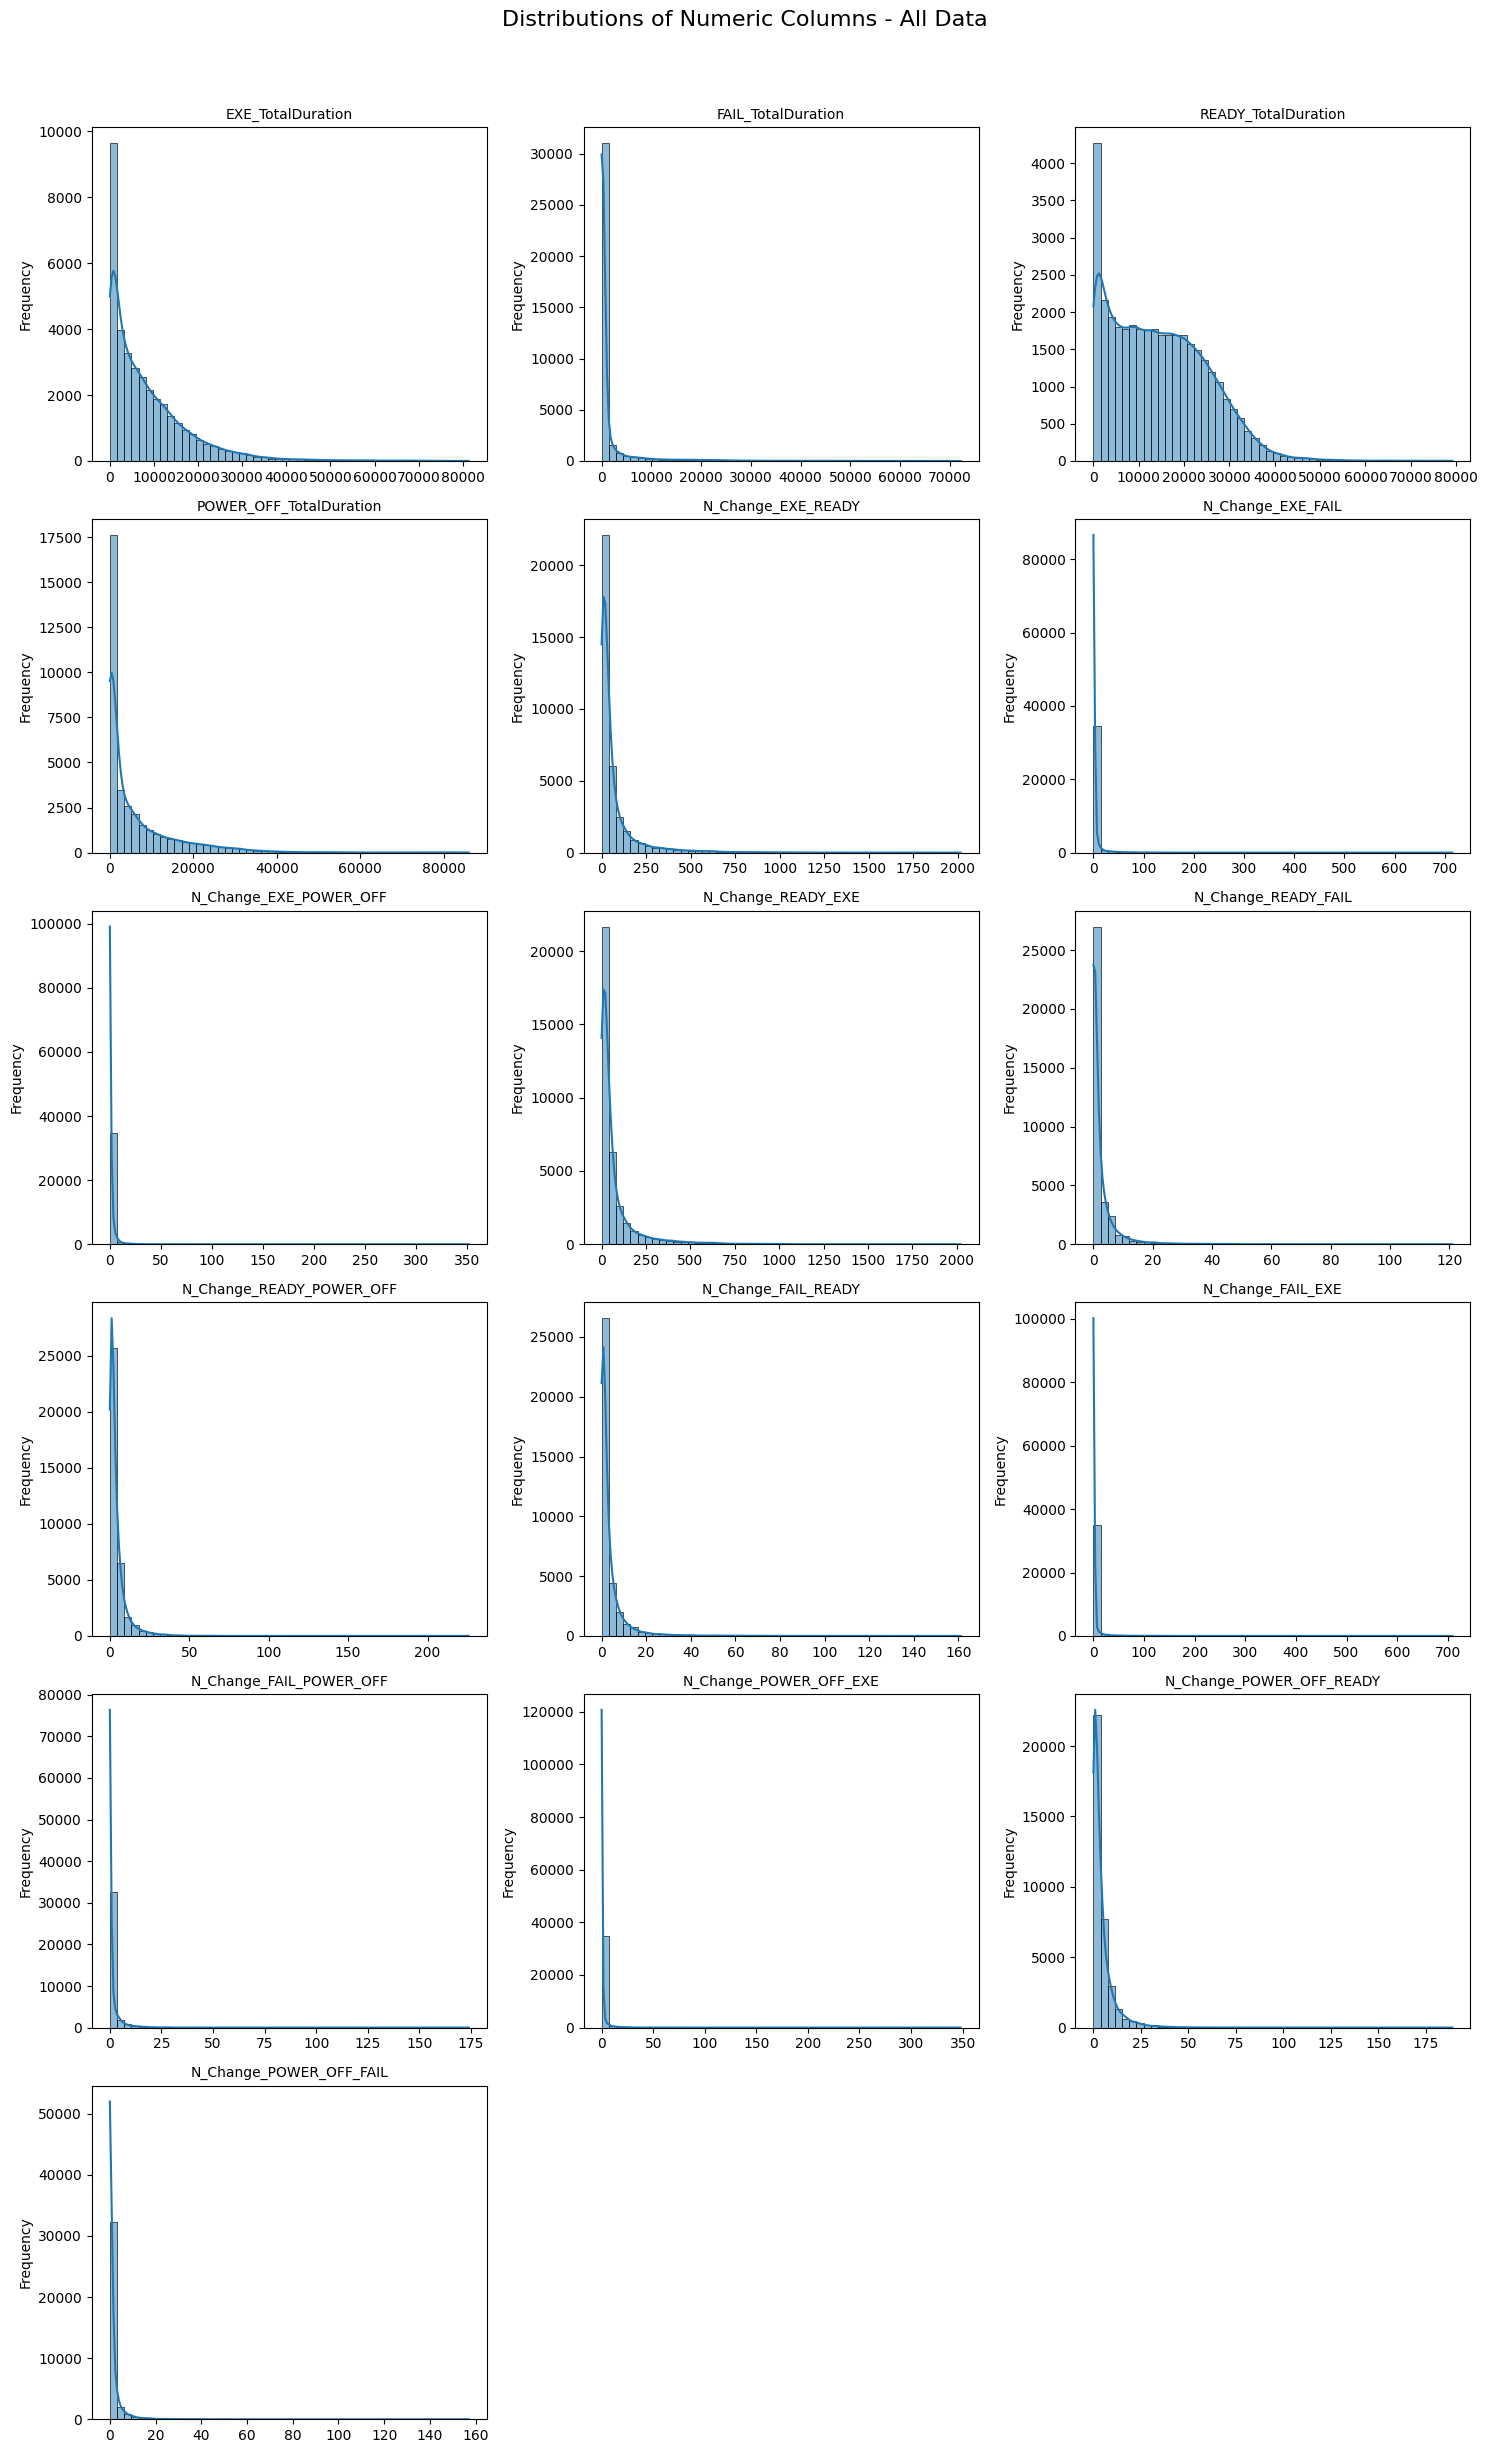

In [106]:
# Histogram plots for all numeric columns
def plot_all_distributions(df, title_suffix="All Data"):
    numeric_cols = [
        'EXE_TotalDuration', 'FAIL_TotalDuration', 'READY_TotalDuration', 'POWER_OFF_TotalDuration',
        'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF',
        'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF',
        'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF',
        'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'
    ]


    cols_present = [col for col in numeric_cols if col in df.columns]

    n_cols = 3
    n_rows = (len(cols_present) + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    plt.suptitle(f"Distributions of Numeric Columns - {title_suffix}", fontsize=16, y=1.02)

    for i, col in enumerate(cols_present, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col].dropna(), bins=50, kde=True)
        plt.title(col, fontsize=10)
        plt.xlabel("")
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()
 
plot_all_distributions(df, title_suffix="All Data")

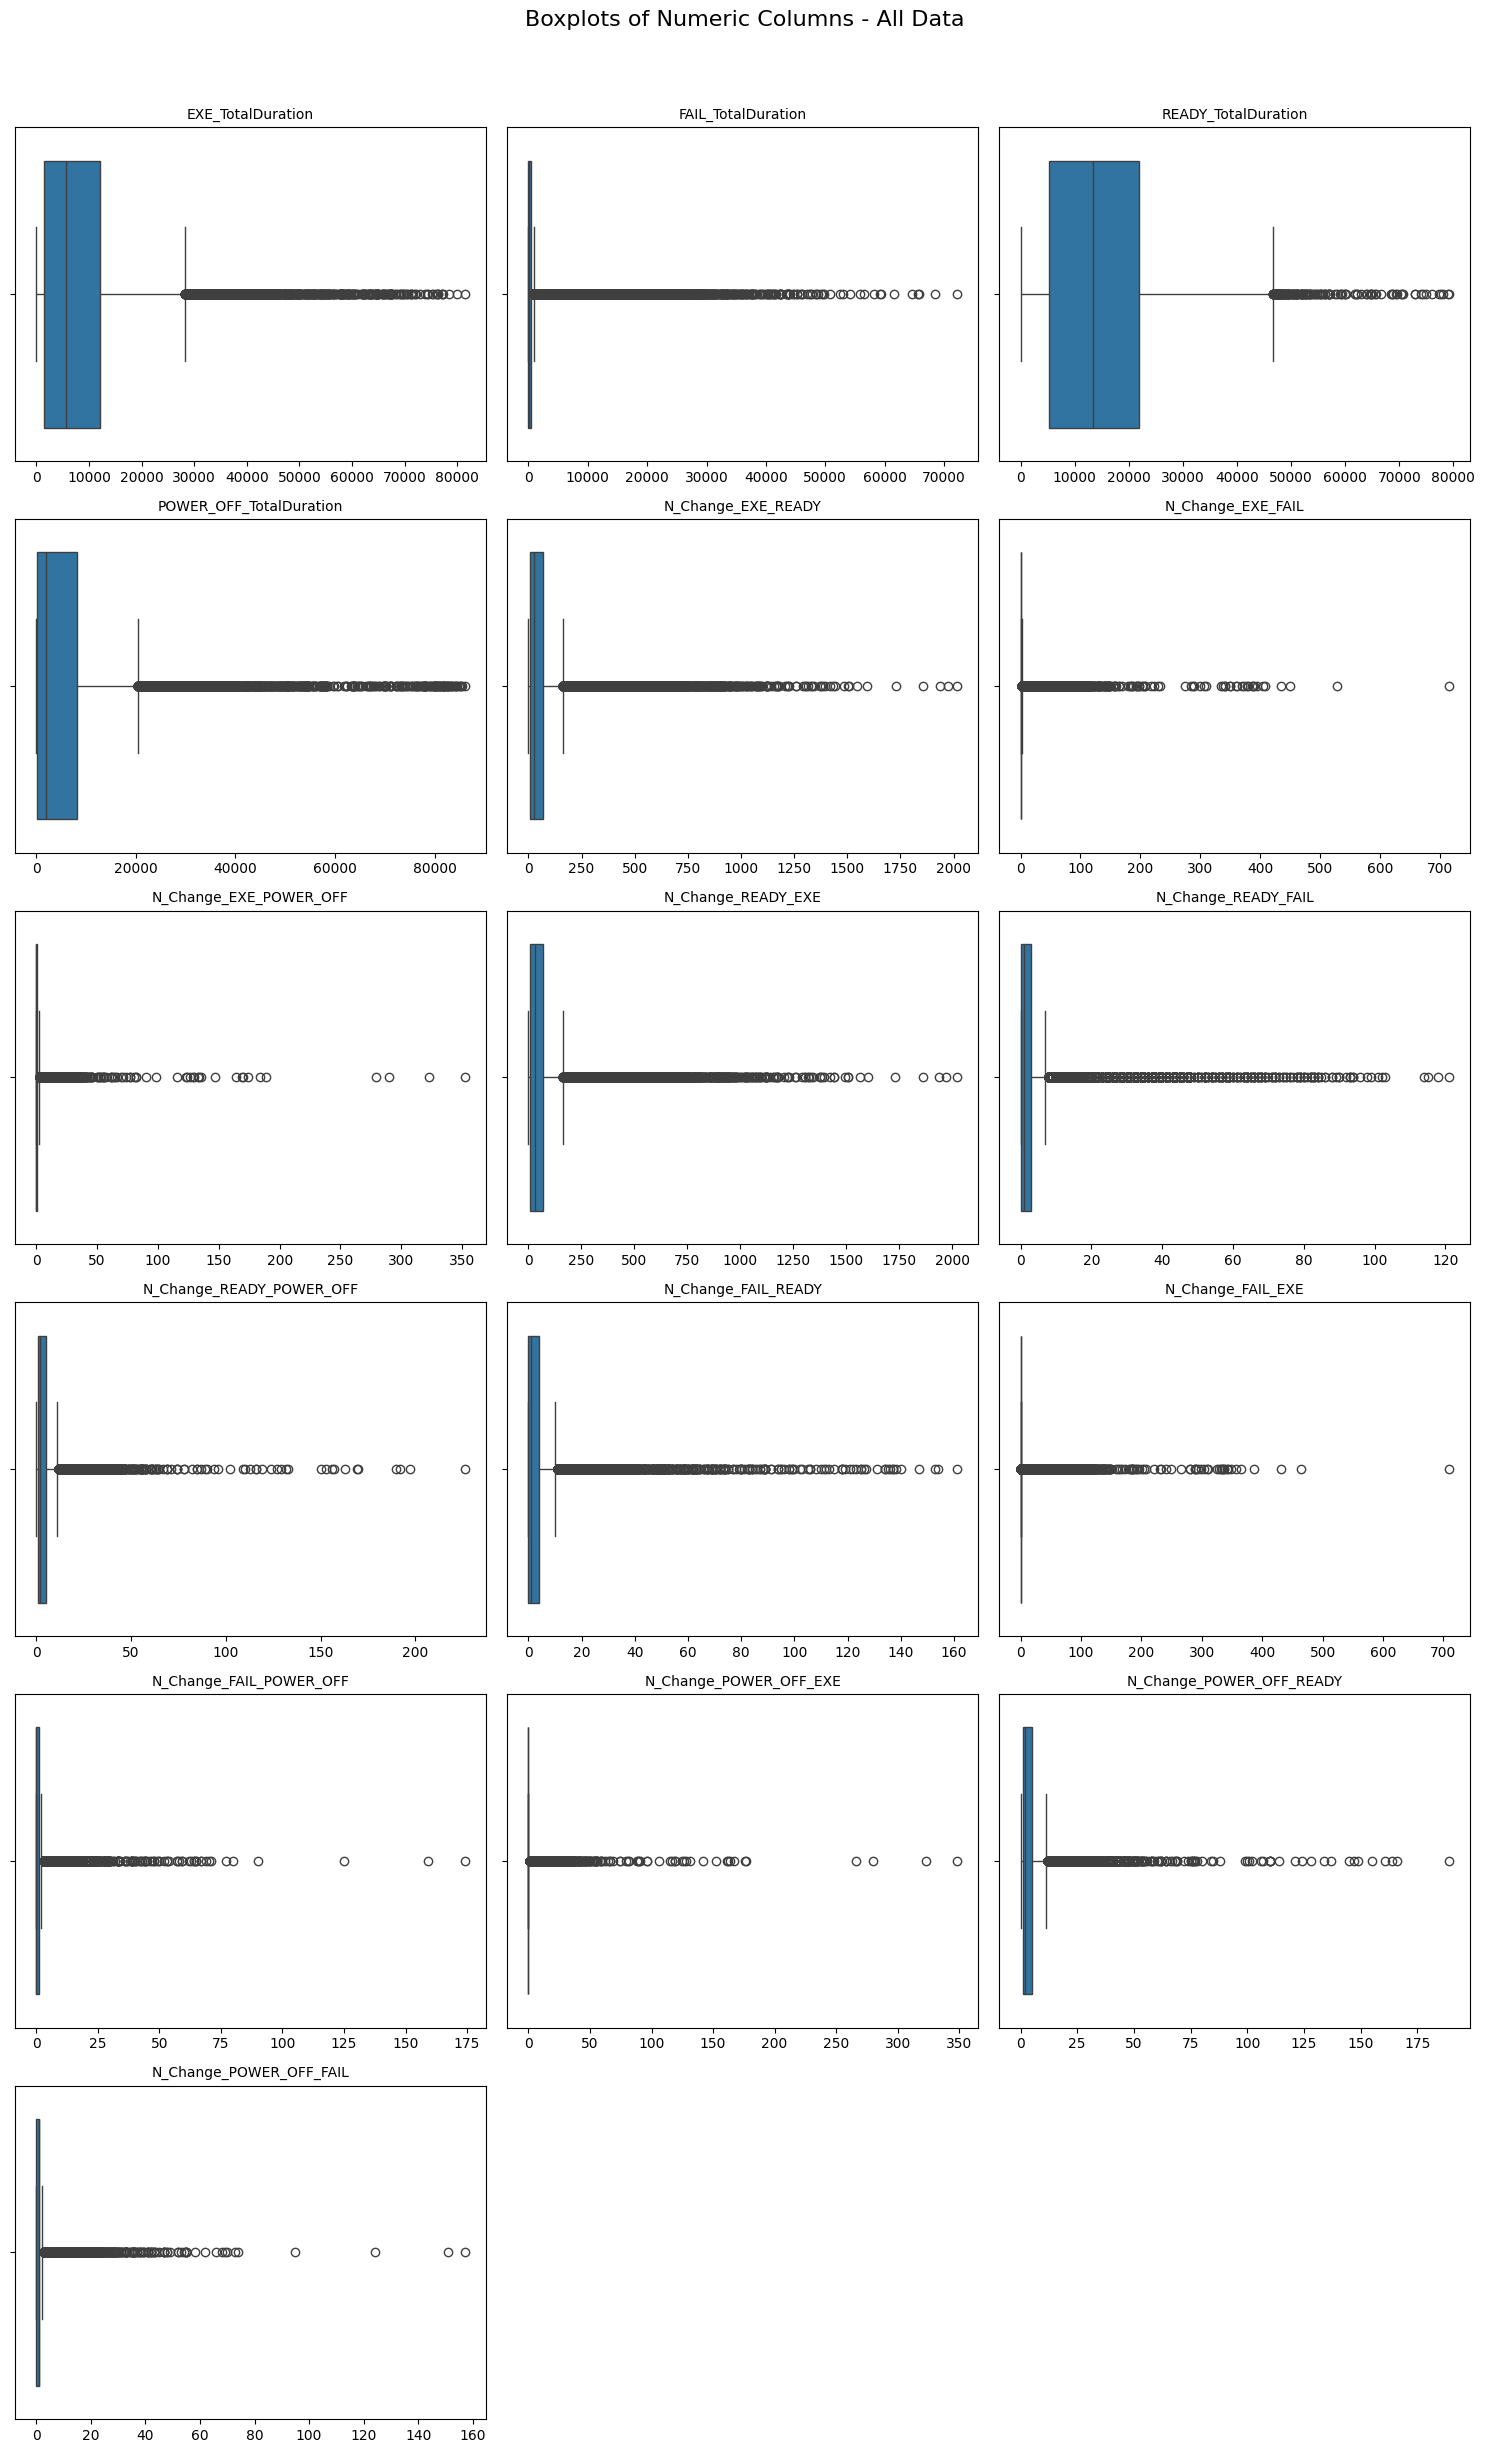

In [107]:
# Boxplots for all numeric columns

def plot_all_boxplots(df, title_suffix="All Data"):
    numeric_cols = [
        'EXE_TotalDuration', 'FAIL_TotalDuration', 'READY_TotalDuration', 'POWER_OFF_TotalDuration',
        'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF',
        'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF',
        'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF',
        'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'
    ]


    cols_present = [col for col in numeric_cols if col in df.columns]

    n_cols = 3
    n_rows = (len(cols_present) + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    plt.suptitle(f"Boxplots of Numeric Columns - {title_suffix}", fontsize=16, y=1.02)

    for i, col in enumerate(cols_present, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=df[col])
        plt.title(col, fontsize=10)
        plt.xlabel("")
        plt.ylabel("")

    plt.tight_layout()
    plt.show()

plot_all_boxplots(df, title_suffix="All Data")

### Interpretation
- Exploratory data analysis revealed that most numeric features were strongly *right-skewed*.
- This distribution indicates long tails toward higher values, a common pattern in machine usage data, where most units operate under normal conditions (short durations and few transitions), while a smaller subset experiences prolonged failures or abnormal behaviors.
- Boxplots confirmed this trend, showing narrow interquartile ranges and numerous high-value outliers.

### Possible solutions for skewed distributions:
Because these outliers likely represent genuine abnormal events rather than data errors, they were retained for analysis.  
- log transformation to reduce skewness
- robust scaling (median and IQR) to reduce outlier influence

## 2-4- Verification
In this section, we verify the data quality by checking for:
-  Missing values and reasons behind them to understand how to handle them.
- Checking for duplicates.
- Finding any possible inconsistencies.

### 2-4-1- Missing Values
Here we only check how many missing values are there in each column. The reasons behind missing values and how to handle them will be discussed in the Data Preparation phase.

In [108]:
# number of missing values per column
df.isnull().sum().sort_values(ascending=False)

Shipment Date               655
Subtechnology_Name_ITA       59
Serial Number                 0
N_Change_READY_EXE            0
N_Change_POWER_OFF_READY      0
N_Change_POWER_OFF_EXE        0
N_Change_FAIL_POWER_OFF       0
N_Change_FAIL_READY           0
N_Change_FAIL_EXE             0
N_Change_READY_POWER_OFF      0
N_Change_READY_FAIL           0
N_Change_EXE_FAIL             0
N_Change_EXE_POWER_OFF        0
Date                          0
N_Change_EXE_READY            0
READY_TotalDuration           0
POWER_OFF_TotalDuration       0
FAIL_TotalDuration            0
EXE_TotalDuration             0
Manufacturing Date            0
N_Change_POWER_OFF_FAIL       0
dtype: int64

In [109]:
# Percentage of missing values per column
(df.isnull().sum().sort_values(ascending=False) / len(df)) * 100

Shipment Date              1.81
Subtechnology_Name_ITA     0.16
Serial Number              0.00
N_Change_READY_EXE         0.00
N_Change_POWER_OFF_READY   0.00
N_Change_POWER_OFF_EXE     0.00
N_Change_FAIL_POWER_OFF    0.00
N_Change_FAIL_READY        0.00
N_Change_FAIL_EXE          0.00
N_Change_READY_POWER_OFF   0.00
N_Change_READY_FAIL        0.00
N_Change_EXE_FAIL          0.00
N_Change_EXE_POWER_OFF     0.00
Date                       0.00
N_Change_EXE_READY         0.00
READY_TotalDuration        0.00
POWER_OFF_TotalDuration    0.00
FAIL_TotalDuration         0.00
EXE_TotalDuration          0.00
Manufacturing Date         0.00
N_Change_POWER_OFF_FAIL    0.00
dtype: float64

In [110]:
# Records where all operational duration features are zero
columns_to_check = ['EXE_TotalDuration', 'FAIL_TotalDuration', 'READY_TotalDuration', 'POWER_OFF_TotalDuration']
num_of_zero_rows = (df[columns_to_check] == 0).all(axis=1).sum()
df[(df[columns_to_check] == 0).all(axis=1)]

Serial Number                     Date Subtechnology_Name_ITA  \
35655       MC_2193  2025-03-26 00:00:00.000                 sub_10   

                 Shipment Date       Manufacturing Date  EXE_TotalDuration  \
35655  2024-12-06 00:00:00.000  2024-10-30 00:00:00.000                  0   

       FAIL_TotalDuration  POWER_OFF_TotalDuration  READY_TotalDuration  \
35655                   0                        0                    0   

       N_Change_EXE_READY  N_Change_EXE_FAIL  N_Change_EXE_POWER_OFF  \
35655                   0                  0                       0   

       N_Change_READY_EXE  N_Change_READY_FAIL  N_Change_READY_POWER_OFF  \
35655                   0                    0                         0   

       N_Change_FAIL_EXE  N_Change_FAIL_READY  N_Change_FAIL_POWER_OFF  \
35655                  0                    0                        0   

       N_Change_POWER_OFF_EXE  N_Change_POWER_OFF_READY  \
35655                       0                         0   

       N_Change_POWER_OFF_FAIL  
35655                        0

### 2-4-2- Duplicates
We check for duplicate records in the dataset. If any duplicates are found, we first make sure they are exact duplicates across all columns. If they are, we can drop the duplicate rows to ensure each record is unique.

In [111]:
# duplicate records
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


# 3- Data Preparation
The data preparation phase ensured that the dataset was clean, consistent, and properly formatted for clustering and classification.

## 3-1- Data Selection: 
We already did all the selection steps in the data understanding phase.

## 3-4- Data Integration: 
Not needed as we have a single unified dataset, and other aggregations were done in powerBI.

## 3-5- Data Formatting: 
Not needed as the dataset is already in a suitable format for analysis.



## 3-2- Data Cleansing: 
This step involved addressing missing values, verifying data types, identifying and handling outliers, and selecting relevant subsets for analysis.

### 3-2-1- Missing Values Handling:
Discussions with domain experts revealed that missing operational durations typically indicated zero time spent in a specific state rather than a recording error. Therefore:

- Missing `operational duration` values were imputed with zeros.
- Rows where all `operational duration` features were zero were removed, as they represented days when the machine was inactive or disconnected from the IoT system.
- Records missing `Subtechnology_Name_ITA` were dropped, because based on the discuussions with the domain expert, they are missing at random.
- Records missing `Shipment Date` were dropped, because based on the discuussions with the domain expert, they are te machines still in production.

In [112]:
# Remove records where all operational duration features are zero
cleaned_df = df[~(df[columns_to_check] == 0).all(axis=1)]
print(f"Number of records after removing zero operational duration records: {cleaned_df.shape[0]}")

Number of records after removing zero operational duration records: 36105


In [113]:
# Dropping NULLS
columns_null_to_drop = ["Shipment Date", "Subtechnology_Name_ITA"]
cleaned_df = cleaned_df.dropna(subset=columns_null_to_drop, how='any')
print(f"Number of records after dropping NULLs in {columns_null_to_drop}: {cleaned_df.shape[0]}")


Number of records after dropping NULLs in ['Shipment Date', 'Subtechnology_Name_ITA']: 35391


In [114]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35391 entries, 0 to 36105
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Serial Number             35391 non-null  object
 1   Date                      35391 non-null  object
 2   Subtechnology_Name_ITA    35391 non-null  object
 3   Shipment Date             35391 non-null  object
 4   Manufacturing Date        35391 non-null  object
 5   EXE_TotalDuration         35391 non-null  int64 
 6   FAIL_TotalDuration        35391 non-null  int64 
 7   POWER_OFF_TotalDuration   35391 non-null  int64 
 8   READY_TotalDuration       35391 non-null  int64 
 9   N_Change_EXE_READY        35391 non-null  int64 
 10  N_Change_EXE_FAIL         35391 non-null  int64 
 11  N_Change_EXE_POWER_OFF    35391 non-null  int64 
 12  N_Change_READY_EXE        35391 non-null  int64 
 13  N_Change_READY_FAIL       35391 non-null  int64 
 14  N_Change_READY_POWER_OFF  3

### 3-2-2- Relevant Data Selection
1. Relevant Features:
Non-informative columns such as identifiers (`Serial Number`, `Date`) and metadata (`Shipment Date`, `Manufacturing Date`) were excluded from modeling features but retained for reference and interpretability in the final results.  

2. Relevant Records:
The analysis focused on two representative subtechnologies, `sub_3` and `sub_4`, chosen for their sufficient data volume and operational relevance.

### 3-2-3- Data Type Verification
All columns were verified for correct data types: numerical features were cast as `integers` or `floats`, while temporal fields (`Date`, `Shipment Date`, and `Manufacturing Date`) were converted to `datetime` objects for consistency.

In [115]:
# identifying most important subtechnologies
distinct_groups = cleaned_df['Subtechnology_Name_ITA'].unique()
print(f"Distinct Subtechnology_Name_ITA groups: {distinct_groups}")
print(f"Number of distinct Subtechnology_Name_ITA groups: {len(distinct_groups)}")


subtechnology_group_counts = cleaned_df.groupby('Subtechnology_Name_ITA').size().sort_values(ascending=False)
print(subtechnology_group_counts)

Distinct Subtechnology_Name_ITA groups: ['sub_1' 'sub_2' 'sub_3' 'sub_4' 'sub_5' 'sub_6' 'sub_7' 'sub_8' 'sub_9'
 'sub_10' 'sub_11' 'sub_12' 'sub_13' 'sub_14' 'sub_15' 'sub_16']
Number of distinct Subtechnology_Name_ITA groups: 16
Subtechnology_Name_ITA
sub_3     11003
sub_4      9596
sub_11     5940
sub_6      3083
sub_10     2955
sub_7       954
sub_13      517
sub_12      369
sub_5       299
sub_8       175
sub_14      170
sub_15      137
sub_16      119
sub_1        46
sub_2        17
sub_9        11
dtype: int64


In [116]:
cleaned_df.groupby('Subtechnology_Name_ITA').size().sort_values(ascending=False).head(2)

Subtechnology_Name_ITA
sub_3    11003
sub_4     9596
dtype: int64

In [117]:
# drop the other subtechnologies
top_2_subtechs = cleaned_df.groupby('Subtechnology_Name_ITA').size().sort_values(ascending=False).head(2).index
cleaned_df = cleaned_df[cleaned_df['Subtechnology_Name_ITA'].isin(top_2_subtechs)]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20599 entries, 79 to 35834
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Serial Number             20599 non-null  object
 1   Date                      20599 non-null  object
 2   Subtechnology_Name_ITA    20599 non-null  object
 3   Shipment Date             20599 non-null  object
 4   Manufacturing Date        20599 non-null  object
 5   EXE_TotalDuration         20599 non-null  int64 
 6   FAIL_TotalDuration        20599 non-null  int64 
 7   POWER_OFF_TotalDuration   20599 non-null  int64 
 8   READY_TotalDuration       20599 non-null  int64 
 9   N_Change_EXE_READY        20599 non-null  int64 
 10  N_Change_EXE_FAIL         20599 non-null  int64 
 11  N_Change_EXE_POWER_OFF    20599 non-null  int64 
 12  N_Change_READY_EXE        20599 non-null  int64 
 13  N_Change_READY_FAIL       20599 non-null  int64 
 14  N_Change_READY_POWER_OFF  

In [118]:
cleaned_df["Date"] = pd.to_datetime(cleaned_df["Date"], errors="coerce")

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20599 entries, 79 to 35834
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Serial Number             20599 non-null  object        
 1   Date                      20599 non-null  datetime64[ns]
 2   Subtechnology_Name_ITA    20599 non-null  object        
 3   Shipment Date             20599 non-null  object        
 4   Manufacturing Date        20599 non-null  object        
 5   EXE_TotalDuration         20599 non-null  int64         
 6   FAIL_TotalDuration        20599 non-null  int64         
 7   POWER_OFF_TotalDuration   20599 non-null  int64         
 8   READY_TotalDuration       20599 non-null  int64         
 9   N_Change_EXE_READY        20599 non-null  int64         
 10  N_Change_EXE_FAIL         20599 non-null  int64         
 11  N_Change_EXE_POWER_OFF    20599 non-null  int64         
 12  N_Change_READY_EXE    

### 3-2-4- Handling Outliers

Numeric features exhibited strong right skewness, with many low-duration values and few extreme ones. Because these extremes likely represented meaningful rare events (e.g., long failures or abnormal operations), outliers were retained rather than removed.  
A *logarithmic transformation* was tested to reduce their influence, but it degraded clustering quality by compressing meaningful behavioral variation. Therefore, the transformation was discarded, and outlier effects were later mitigated through appropriate feature scaling.

## 3-3- Data Construction
After cleaning, feature transformation and scaling were performed to enhance model interpretability and performance.
### 3-3-1- Feature Engineering
1. Convert Operational Durations to Minutes:
Operational durations were converted from seconds to minutes to improve readability for domain experts.  
Transition count features were preserved to maintain behavioral integrity, as they capture how often machines shift between operational states.

In [119]:
# Convert Operational Durations to Minutes
duration_cols = ['EXE_TotalDuration', 'FAIL_TotalDuration', 'READY_TotalDuration', 'POWER_OFF_TotalDuration']

for col in duration_cols:
    cleaned_df[f"{col}_min"] = (cleaned_df[col] // 60).astype(int)

# Drop original duration columns
cleaned_df = cleaned_df.drop(columns=duration_cols)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20599 entries, 79 to 35834
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Serial Number                20599 non-null  object        
 1   Date                         20599 non-null  datetime64[ns]
 2   Subtechnology_Name_ITA       20599 non-null  object        
 3   Shipment Date                20599 non-null  object        
 4   Manufacturing Date           20599 non-null  object        
 5   N_Change_EXE_READY           20599 non-null  int64         
 6   N_Change_EXE_FAIL            20599 non-null  int64         
 7   N_Change_EXE_POWER_OFF       20599 non-null  int64         
 8   N_Change_READY_EXE           20599 non-null  int64         
 9   N_Change_READY_FAIL          20599 non-null  int64         
 10  N_Change_READY_POWER_OFF     20599 non-null  int64         
 11  N_Change_FAIL_EXE            20599 non-null  

#### Seperating Subtechnologies:

In [120]:
sub_3_df = cleaned_df[cleaned_df["Subtechnology_Name_ITA"] == "sub_3"].copy().reset_index(drop=True)
sub_4_df = cleaned_df[cleaned_df["Subtechnology_Name_ITA"] == "sub_4"].copy().reset_index(drop=True)


print(f"sub_3_df shape: {sub_3_df.shape}")
print(f"sub_4_df shape: {sub_4_df.shape}")

sub_3_df shape: (11003, 21)
sub_4_df shape: (9596, 21)


### 3-3-2- Feature Scaling
Because features varied widely in magnitude (e.g., durations in thousands vs. transition counts in tens), scaling was essential.  
Both *RobustScaler* and *MinMaxScaler* were tested. Although robust scaling mitigated outlier effects, it led to poorer clustering separation.  
Therefore, **MinMax scaling** was selected, as it provided clearer cluster separation and more interpretable results.

In [121]:
# Min-Max Scaling function
def min_max_scaling(df):
    feature_cols = [
        'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 
        'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 
        'N_Change_FAIL_EXE', 'N_Change_FAIL_READY', 'N_Change_FAIL_POWER_OFF',
        'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL', 
        'EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min',
        'POWER_OFF_TotalDuration_min'
    ]
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df_scaled

In [122]:
sub_3_df_scaled = min_max_scaling(sub_3_df)
sub_4_df_scaled = min_max_scaling(sub_4_df)

## Feature Selection
After data cleaning and construction, feature selection was performed to eliminate redundant or uninformative variables prior to clustering and classification.
- Variance Analysis: Variance thresholding was explored, but after applying *MinMaxScaler* (which normalizes each feature to the [0,1] range), many features showed very small numerical variance, and columns that were constant within a subset became exactly zero-variance. Using *logarithmic/robust* scaling increased variance numerically, but degraded clustering separability. Since the features capture meaningful behavior, none were removed by variance thresholding.

- Correlation Analysis: To minimize redundancy, a Pearson correlation matrix was computed. When two features had a correlation coefficient above `0.7`, one was removed to retain only the most representative variable.  
This step improved feature independence and enhanced the stability of subsequent clustering and classification models.

#### Variance Thresholding

In [123]:
numeric_cols = [
        'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 
        'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 
        'N_Change_FAIL_EXE', 'N_Change_FAIL_READY', 'N_Change_FAIL_POWER_OFF',
        'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL', 
        'EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min',
        'POWER_OFF_TotalDuration_min'
    ]
variances_sub_3 = sub_3_df_scaled[numeric_cols].var().sort_values()
print("Variance of numeric features in sub_3 (ascending):\n")
print(variances_sub_3)
variances_sub_4 = sub_4_df_scaled[numeric_cols].var().sort_values()
print("Variance of numeric features in sub_4 (ascending):\n")
print(variances_sub_4)


Variance of numeric features in sub_3 (ascending):

N_Change_POWER_OFF_EXE        0.00
N_Change_POWER_OFF_FAIL       0.00
N_Change_FAIL_POWER_OFF       0.00
N_Change_POWER_OFF_READY      0.00
N_Change_EXE_FAIL             0.00
N_Change_EXE_POWER_OFF        0.00
N_Change_FAIL_EXE             0.00
N_Change_FAIL_READY           0.00
N_Change_EXE_READY            0.00
N_Change_READY_EXE            0.00
N_Change_READY_FAIL           0.00
N_Change_READY_POWER_OFF      0.01
FAIL_TotalDuration_min        0.01
POWER_OFF_TotalDuration_min   0.01
READY_TotalDuration_min       0.02
EXE_TotalDuration_min         0.02
dtype: float64
Variance of numeric features in sub_4 (ascending):

N_Change_POWER_OFF_EXE        0.00
N_Change_POWER_OFF_FAIL       0.00
N_Change_FAIL_POWER_OFF       0.00
N_Change_EXE_POWER_OFF        0.00
N_Change_FAIL_READY           0.00
N_Change_POWER_OFF_READY      0.00
N_Change_EXE_READY            0.00
N_Change_READY_EXE            0.00
N_Change_EXE_FAIL             0.00
N_Chan

#### Pearson's Correlation

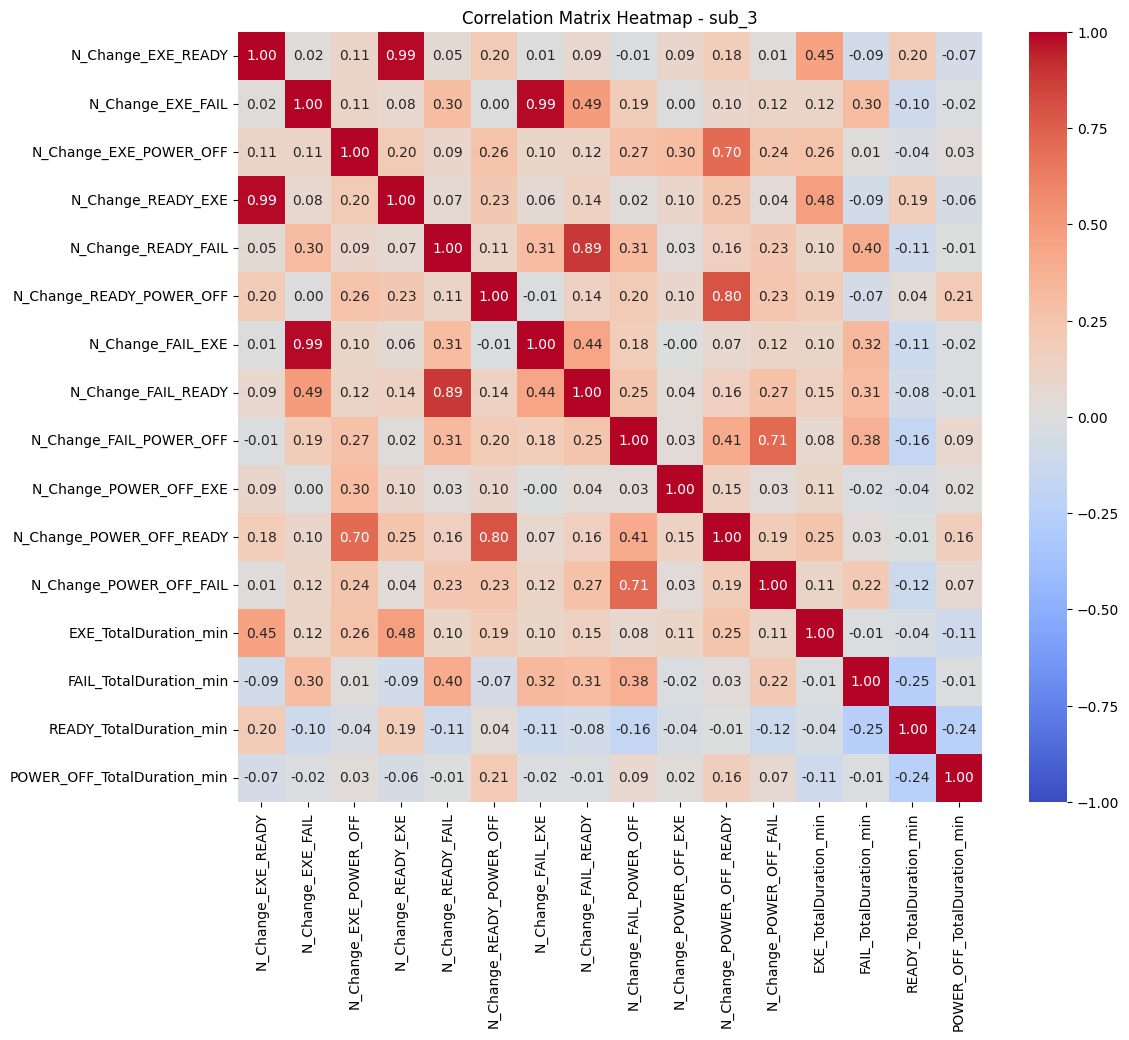

In [124]:
# correlation matrix heatmap for sub_3

corr_matrix_sub_3 = sub_3_df_scaled[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_sub_3, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix Heatmap - sub_3")
plt.show()



#### Droping highly correlated features:
- Since `N_Change_EXE_READY` and `N_Change_READY_EXE` are highly correlated (correlation > 0.9), we can drop one of them to reduce redundancy. We will drop `N_Change_READY_EXE` from the feature set for clustering analysis.
- Also for `N_Change_FAIL_READY` and `N_Change_READY_FAIL`, we will drop `N_Change_READY_FAIL` due to high correlation.
- For `EXE_TotalDuration` and `N_Change_EXE_READY`, we will drop `N_Change_EXE_READY` due to high correlation. It makes sense because the more time a machine spends in execution, the more likely it is to transition to ready state, leading to a higher count of `N_Change_EXE_READY`.
- Same for `N__Change_FAIL_EXE` and `N_Change_EXE_FAIL`, we will drop `N_Change_FAIL_EXE`.
- Finally, for `n_Change_POWER_OFF_READY` and `N_Change_READY_POWER_OFF`, we will drop `N_Change_POWER_OFF_READY` due to high correlation.

In [125]:
# Dropping highly correlated features:
sub_3_df_scaled.drop(columns=['N_Change_READY_EXE', 'N_Change_FAIL_READY',
                             'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_FAIL',
                             'N_Change_POWER_OFF_READY'], inplace=True)

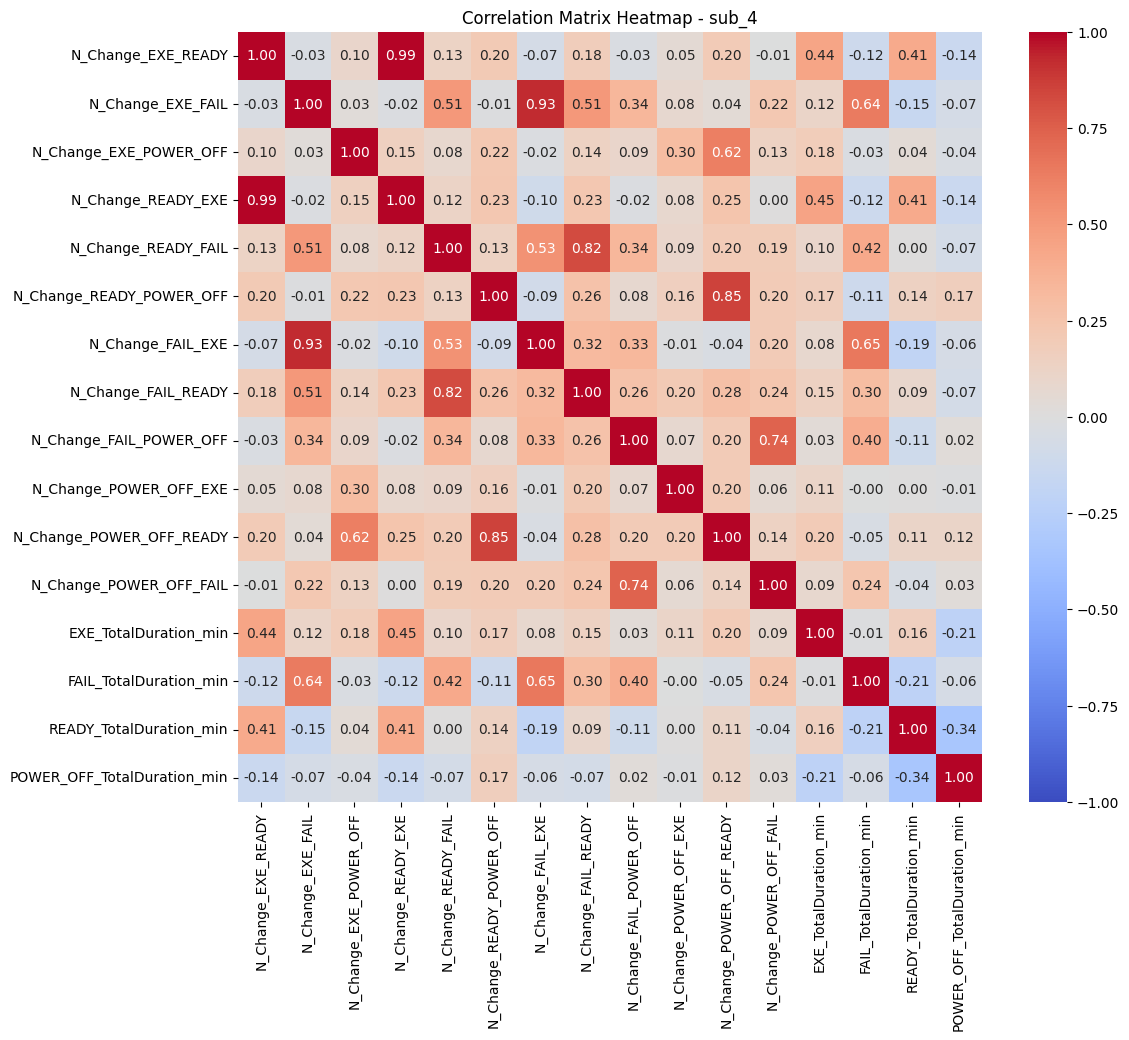

In [126]:
# correlation matrix heatmap for sub_4
corr_matrix_sub_4 = sub_4_df_scaled[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_sub_4, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix Heatmap - sub_4")
plt.show()

In [127]:
# dropping highly correlated features:

sub_4_df_scaled.drop(columns=['N_Change_READY_EXE', 'N_Change_FAIL_READY', 
                              'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_READY', 
                              'N_Change_POWER_OFF_FAIL'], inplace=True)
                              
                             

# 4- Modeling

The modeling phase combines `unsupervised clustering` and `supervised classification` to identify and predict machine behavioral patterns.
## 4-1- Clustering with *k-means*: 
was selected as the primary clustering method for its simplicity, scalability, and ability to segment machines into distinct behavioral groups based on feature similarity.  
- The optimal number of clusters ($k$) was determined using two complementary techniques: `Elbow Method` and `Silhouette Analysis`.
- Separate K-Means models were trained for each subtechnology (`sub_3` and `sub_4`), ensuring that differences in machine design and usage patterns were captured independently.  
- Principal Component Analysis (PCA) was then applied to reduce dimensionality and visualize the clusters in a three-dimensional space.
- Each cluster was then analyzed based on mean operational durations and transition counts to confirm distinct behavioral signatures.


In [128]:
# Function to perform clustering

def clustering(subtechnology_name, manual_k):
    subtechnology_name = str(subtechnology_name)
    print(f"\nProcessing Subtechnology: {subtechnology_name}\n")

    filtered_df = cleaned_df[cleaned_df['Subtechnology_Name_ITA'] == subtechnology_name].copy()

    initial_features = [
        'EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min',
        'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL',
        'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL',
        'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE',
        'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE',
        'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'
    ]

    print(f"Correlation matrix for {subtechnology_name}:\n")
    print(f"Initial features: {initial_features}")

    scaler = MinMaxScaler()
    X_scaled_full = scaler.fit_transform(filtered_df[initial_features])
    scaled_df = pd.DataFrame(X_scaled_full, columns=initial_features, index=filtered_df.index)

    # correlation
    corr_matrix = scaled_df.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"Feature Correlation Heatmap for {subtechnology_name} (scaled)")
    plt.tight_layout(); plt.show()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.7)]
    reduced_features = [c for c in initial_features if c not in to_drop]
    if len(reduced_features) < 2:
        reduced_features = initial_features

    print(f"Highly correlated features to drop (|corr| > 0.7): {to_drop}")
    print(f"Reduced features: {reduced_features} (n={len(reduced_features)})\n")



    # use the scaled+reduced matrix from now on
    X_scaled = scaled_df[reduced_features].values

    # Elbow + silhouette
    inertias = []
    silhouette_scores = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    print("Methods for determining optimal k:\n")
    print(f"Elbow Method and Silhouette Analysis for {subtechnology_name}")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bx-')
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("k")
    plt.ylabel("Sum of Squared Distances (Inertia)")

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'bx-')
    plt.title("Silhouette Scores")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()

    # Best k from silhouette scores
    best_k = k_range[np.argmax(silhouette_scores)]
    print(f"Best k by silhouette: {best_k} (score={max(silhouette_scores):.3f})")

    # performing KMeans with the manual k
    kmeans = KMeans(n_clusters=manual_k, random_state=42)

    # Fitting KMeans with the manual k on the filtered data based on reduced features
    filtered_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

    print(f"Using manual k={manual_k} for {subtechnology_name}")
    print("Cluster centers (scaled space):")
    print(pd.DataFrame(kmeans.cluster_centers_, columns=reduced_features).round(3).to_string())

    # PCA for visualization
    if len(reduced_features) >= 3:
        pca = PCA(n_components=3, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        centroids_pca = pca.transform(kmeans.cluster_centers_)

        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                        c=filtered_df['KMeans_Cluster'], cmap='tab10', alpha=0.6)
        ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
                   marker='X', s=250, edgecolors='black', linewidths=1.2,
                   c=range(manual_k), cmap='tab10', label='Centroids')
        for i, (x, y, z) in enumerate(centroids_pca):
            ax.text(x, y, z, f'C{i}', fontsize=10, weight='bold', ha='center')
        ax.set_title(f"KMeans with {manual_k} clusters for {subtechnology_name}")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        ax.legend(*sc.legend_elements(), title="Clusters")
        plt.show()


    def minutes_to_hms(x):
        return str(datetime.timedelta(seconds=int(x*60))) if pd.notnull(x) else None

    all_duration_cols = ["EXE_TotalDuration_min", "FAIL_TotalDuration_min",
                         "READY_TotalDuration_min", "POWER_OFF_TotalDuration_min"]
    cluster_means = filtered_df.groupby('KMeans_Cluster')[reduced_features].mean()
    cluster_counts = filtered_df['KMeans_Cluster'].value_counts()
    distinct_serial_counts = filtered_df.groupby('KMeans_Cluster')['Serial Number'].nunique()
    cluster_means['Total_Count'] = cluster_counts
    cluster_means['Distinct_Serials'] = distinct_serial_counts
    cluster_means = cluster_means.sort_index()
    cluster_means_formatted = cluster_means.copy()

    for col in all_duration_cols:
        if col in cluster_means_formatted.columns:
            cluster_means_formatted[col] = cluster_means_formatted[col].apply(minutes_to_hms)

    cols = ['Total_Count', 'Distinct_Serials'] + [c for c in cluster_means_formatted.columns
                                                  if c not in ['Total_Count', 'Distinct_Serials']]
    cluster_means_formatted = cluster_means_formatted[cols]

    desc_df = filtered_df[all_duration_cols].describe()
    desc_formatted = pd.DataFrame(index=desc_df.index, columns=desc_df.columns, dtype='object')
    for row in desc_df.index:
        if row == 'count':
            desc_formatted.loc[row] = desc_df.loc[row]
        else:
            desc_formatted.loc[row] = desc_df.loc[row].map(lambda x: minutes_to_hms(x) if pd.notnull(x) else None)

    print(f"Subtechnology: {subtechnology_name}\n")
    print(f"Number of records: {filtered_df.shape[0]}\n")
    print("Cluster Statistics Summary:\n")
    print(desc_formatted.to_string())
    print("\n\nCluster means:\n")
    print(cluster_means_formatted.to_string())
    print("___" * 80)
    print("___" * 80)
    print("\n\n\n")
    print(filtered_df['KMeans_Cluster'].unique())

    available_duration_cols = [col for col in all_duration_cols if col in filtered_df.columns]
    for cluster in sorted(filtered_df['KMeans_Cluster'].dropna().unique()):
        print(f"\n--- Cluster {int(cluster)} ---")
        cluster_df = filtered_df[filtered_df['KMeans_Cluster'] == cluster]
        desc_df = cluster_df[available_duration_cols].describe()
        desc_formatted = pd.DataFrame(index=desc_df.index, columns=desc_df.columns, dtype='object')
        for row in desc_df.index:
            if row == 'count':
                desc_formatted.loc[row] = desc_df.loc[row]
            else:
                desc_formatted.loc[row] = desc_df.loc[row].map(lambda x: minutes_to_hms(x) if pd.notnull(x) else None)
        print(desc_formatted.to_string()); print("\n")

    # KDE plots
    duration_cols = ["EXE_TotalDuration_min", "READY_TotalDuration_min", "FAIL_TotalDuration_min"]
    color_map = {
        "EXE_TotalDuration_min": "green",
        "READY_TotalDuration_min": "orange",
        "FAIL_TotalDuration_min": "red",
    }

    clusters = sorted(filtered_df['KMeans_Cluster'].dropna().unique())
    total_plots = len(clusters)

    x_max = float(filtered_df[duration_cols].quantile(0.99).max())
    x_min = 0.0

    fig, axes = plt.subplots(
        nrows=total_plots, ncols=1,
        figsize=(10, 3.6 * total_plots),
        sharex=True
    )
    if total_plots == 1:
        axes = [axes]

    for i, cluster in enumerate(clusters):
        ax = axes[i]
        cluster_data = filtered_df[filtered_df['KMeans_Cluster'] == cluster]

        for feature in duration_cols:
            if feature in cluster_data.columns:
                series = cluster_data[feature].dropna()

                if series.empty or series.nunique() < 2:
                    continue

                sns.kdeplot(
                    x=series,
                    ax=ax,
                    fill=False,
                    clip=(0, None),
                    bw_adjust=0.9,
                    color=color_map[feature],
                    label=feature
                )

        ax.set_xlim(x_min, x_max)
        ax.set_ylabel("Density")
        ax.set_title(f"Cluster {int(cluster)} – {subtechnology_name}")
        ax.legend(loc="upper right", fontsize=9, frameon=False)

    axes[-1].set_xlabel("Duration (minutes)")
    fig.suptitle("Duration Distributions per Cluster (EXE / READY / FAIL)", y=0.995, fontsize=12)
    plt.tight_layout()
    plt.show()

    cols_to_save = initial_features + ["KMeans_Cluster", "Serial Number", "Date", "Subtechnology_Name_ITA", "Shipment Date", "Manufacturing Date"]
    filtered_df[cols_to_save].to_csv(f"clustering_output_kmeans/{subtechnology_name}.csv", index=False)


Processing Subtechnology: sub_3

Correlation matrix for sub_3:

Initial features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']


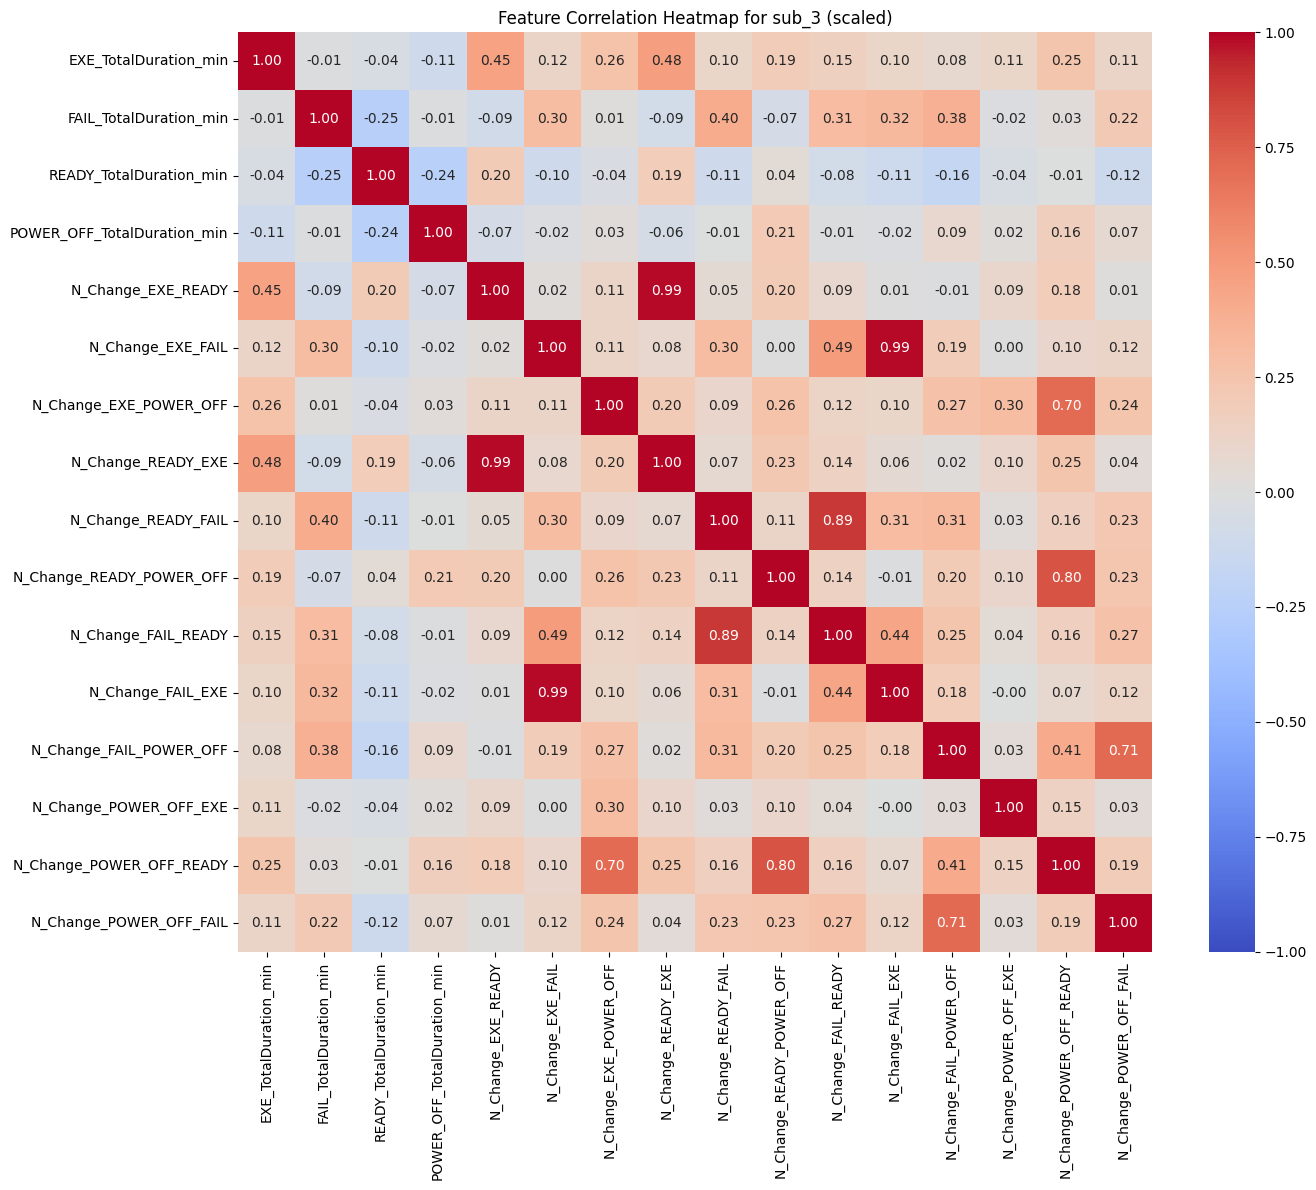

Highly correlated features to drop (|corr| > 0.7): ['N_Change_READY_EXE', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']
Reduced features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE'] (n=11)

Methods for determining optimal k:

Elbow Method and Silhouette Analysis for sub_3


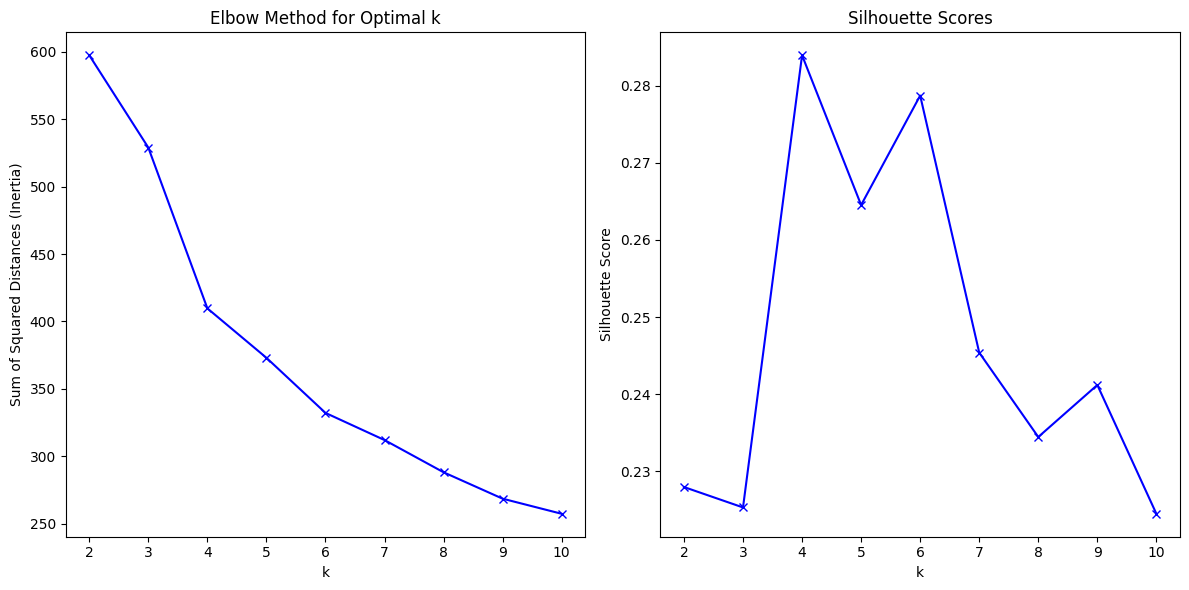

Best k by silhouette: 4 (score=0.284)
Using manual k=4 for sub_3
Cluster centers (scaled space):
   EXE_TotalDuration_min  FAIL_TotalDuration_min  READY_TotalDuration_min  POWER_OFF_TotalDuration_min  N_Change_EXE_READY  N_Change_EXE_FAIL  N_Change_EXE_POWER_OFF  N_Change_READY_FAIL  N_Change_READY_POWER_OFF  N_Change_FAIL_POWER_OFF  N_Change_POWER_OFF_EXE
0                   0.09                    0.00                     0.30                         0.02                0.05               0.00                    0.01                 0.01                      0.06                     0.00                    0.00
1                   0.05                    0.01                     0.09                         0.09                0.02               0.00                    0.01                 0.01                      0.06                     0.01                    0.00
2                   0.11                    0.36                     0.05                         0.04               

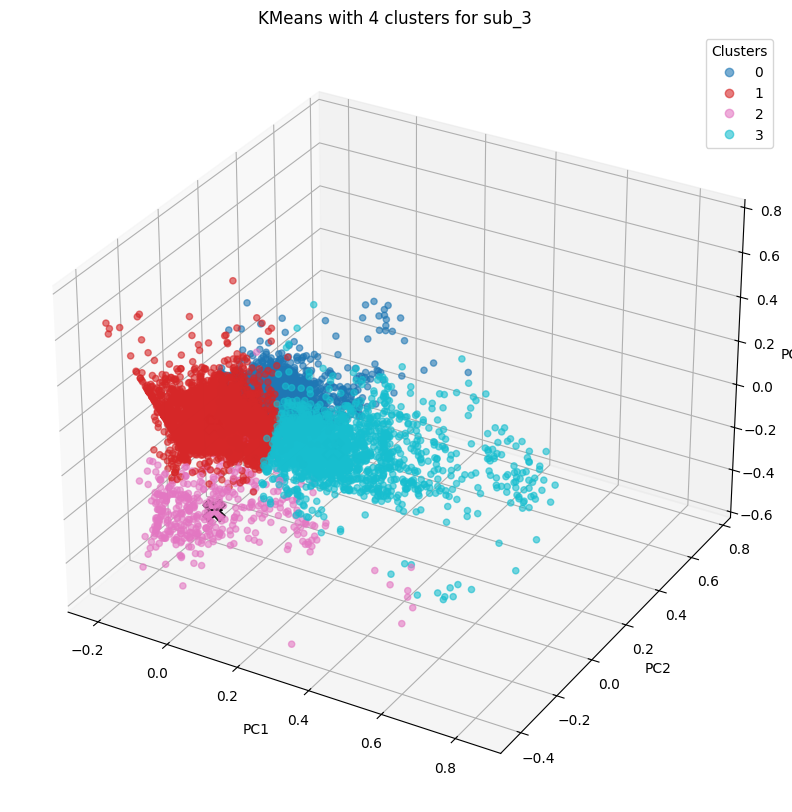

Subtechnology: sub_3

Number of records: 11003

Cluster Statistics Summary:

      EXE_TotalDuration_min FAIL_TotalDuration_min READY_TotalDuration_min POWER_OFF_TotalDuration_min
count              11003.00               11003.00                11003.00                    11003.00
mean                2:41:36                0:16:39                 4:14:03                     0:59:02
std                 2:51:29                1:03:42                 2:43:09                     1:49:41
min                 0:00:00                0:00:00                 0:00:00                     0:00:00
25%                 0:35:00                0:00:00                 2:04:00                     0:01:00
50%                 1:53:00                0:00:00                 4:09:00                     0:13:00
75%                 3:52:00                0:02:00                 6:10:00                     1:09:00
max                21:23:00               13:26:00                21:40:00                    21:46

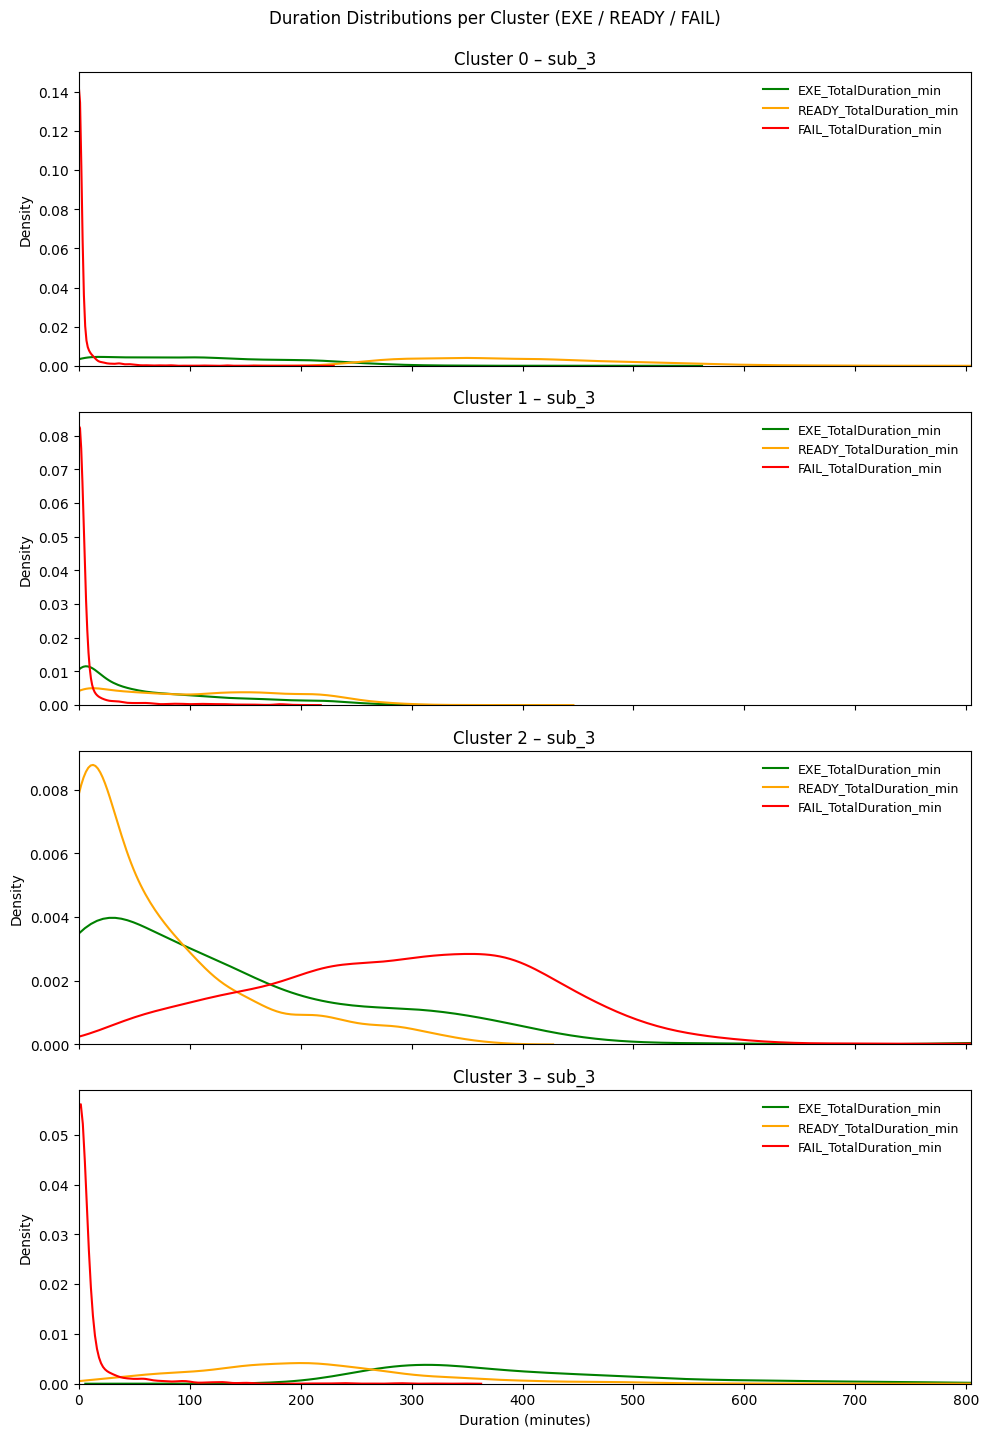

In [129]:
clustering('sub_3', 4)

In [130]:
labeled_sub_3 = pd.read_csv("clustering_output_kmeans/sub_3.csv")
cluster_label_map_sub_3 = {
    0: "Idle–Stable (High Ready Time)",
    1: "Normal Operation (Balanced Use)",
    2: "Faulty / High Failure Duration",
    3: "High Execution / Productive"
}
labeled_sub_3['Cluster_Label'] = labeled_sub_3['KMeans_Cluster'].map(cluster_label_map_sub_3)
labeled_sub_3.drop(columns=['KMeans_Cluster'], inplace=True)
labeled_sub_3.to_csv("clustering_output_kmeans/sub_3_labeled.csv", index=False)



Processing Subtechnology: sub_4

Correlation matrix for sub_4:

Initial features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']


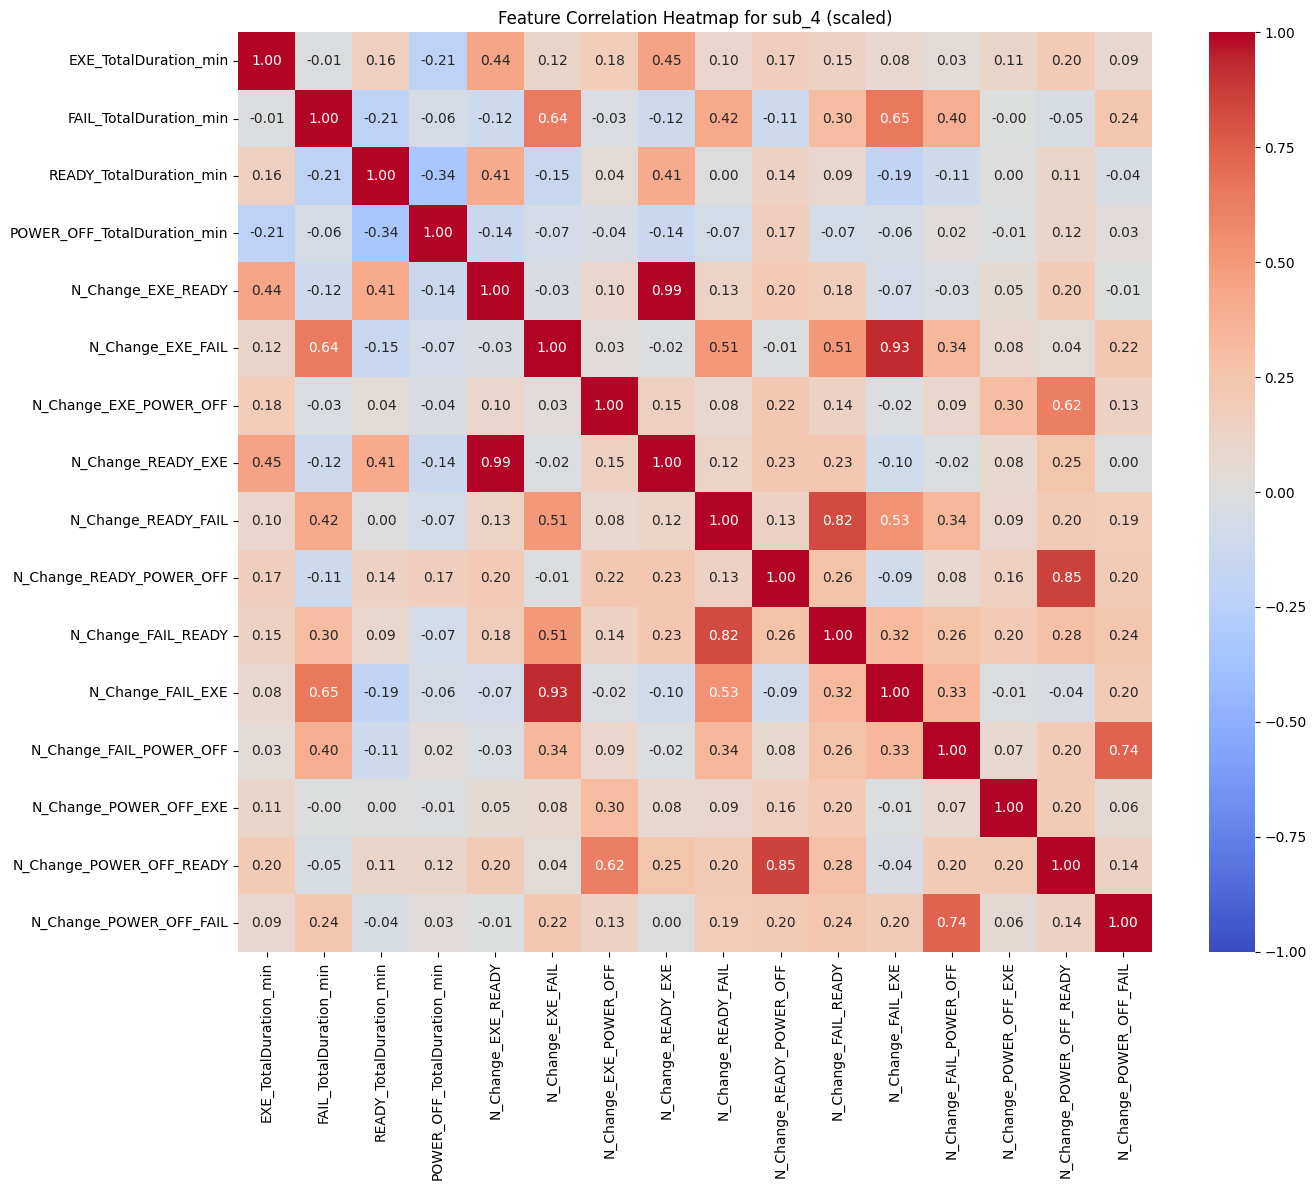

Highly correlated features to drop (|corr| > 0.7): ['N_Change_READY_EXE', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']
Reduced features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE'] (n=11)

Methods for determining optimal k:

Elbow Method and Silhouette Analysis for sub_4


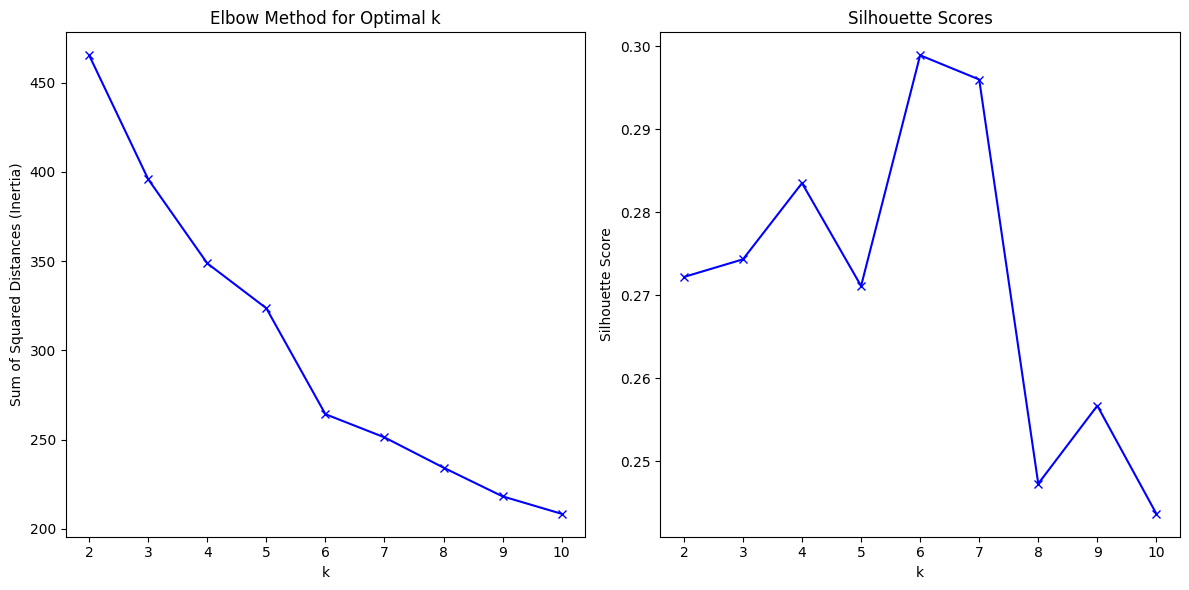

Best k by silhouette: 6 (score=0.299)
Using manual k=6 for sub_4
Cluster centers (scaled space):
   EXE_TotalDuration_min  FAIL_TotalDuration_min  READY_TotalDuration_min  POWER_OFF_TotalDuration_min  N_Change_EXE_READY  N_Change_EXE_FAIL  N_Change_EXE_POWER_OFF  N_Change_READY_FAIL  N_Change_READY_POWER_OFF  N_Change_FAIL_POWER_OFF  N_Change_POWER_OFF_EXE
0                   0.26                    0.00                     0.18                         0.03                0.07               0.01                    0.02                 0.02                      0.07                     0.01                    0.01
1                   0.09                    0.01                     0.23                         0.11                0.07               0.01                    0.02                 0.04                      0.20                     0.02                    0.01
2                   0.03                    0.01                     0.07                         0.31               

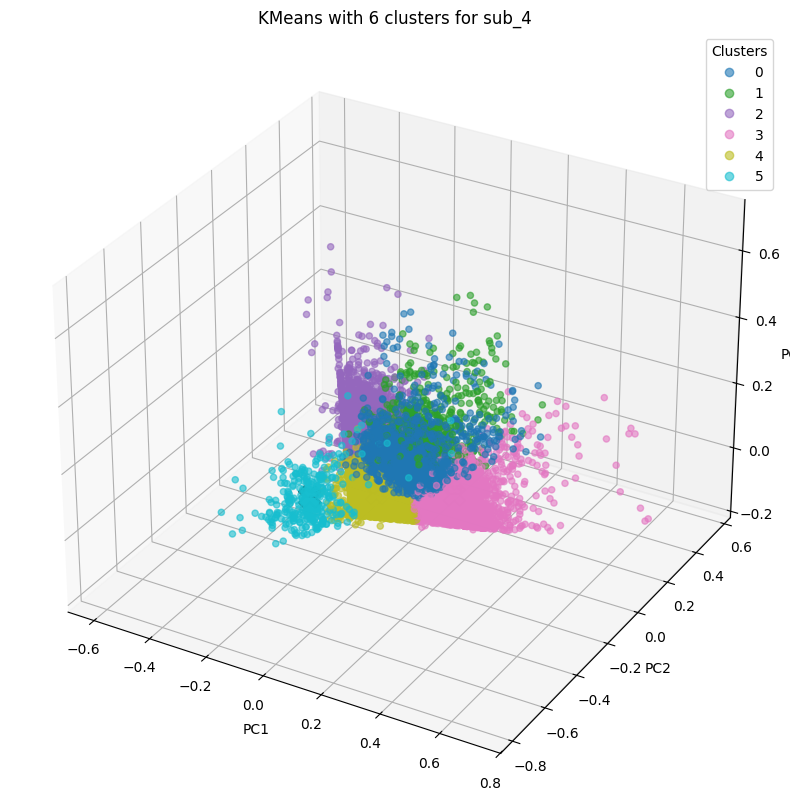

Subtechnology: sub_4

Number of records: 9596

Cluster Statistics Summary:

      EXE_TotalDuration_min FAIL_TotalDuration_min READY_TotalDuration_min POWER_OFF_TotalDuration_min
count               9596.00                9596.00                 9596.00                     9596.00
mean                1:53:17                0:18:58                 4:08:47                     1:41:53
std                 2:11:20                1:21:38                 2:58:37                     2:24:44
min                 0:00:00                0:00:00                 0:00:00                     0:00:00
25%                 0:19:00                0:00:00                 1:32:00                     0:03:00
50%                 1:11:00                0:00:00                 3:57:30                     0:39:00
75%                 2:43:15                0:02:00                 6:19:00                     2:19:00
max                22:36:00               20:02:00                21:59:00                    21:56:

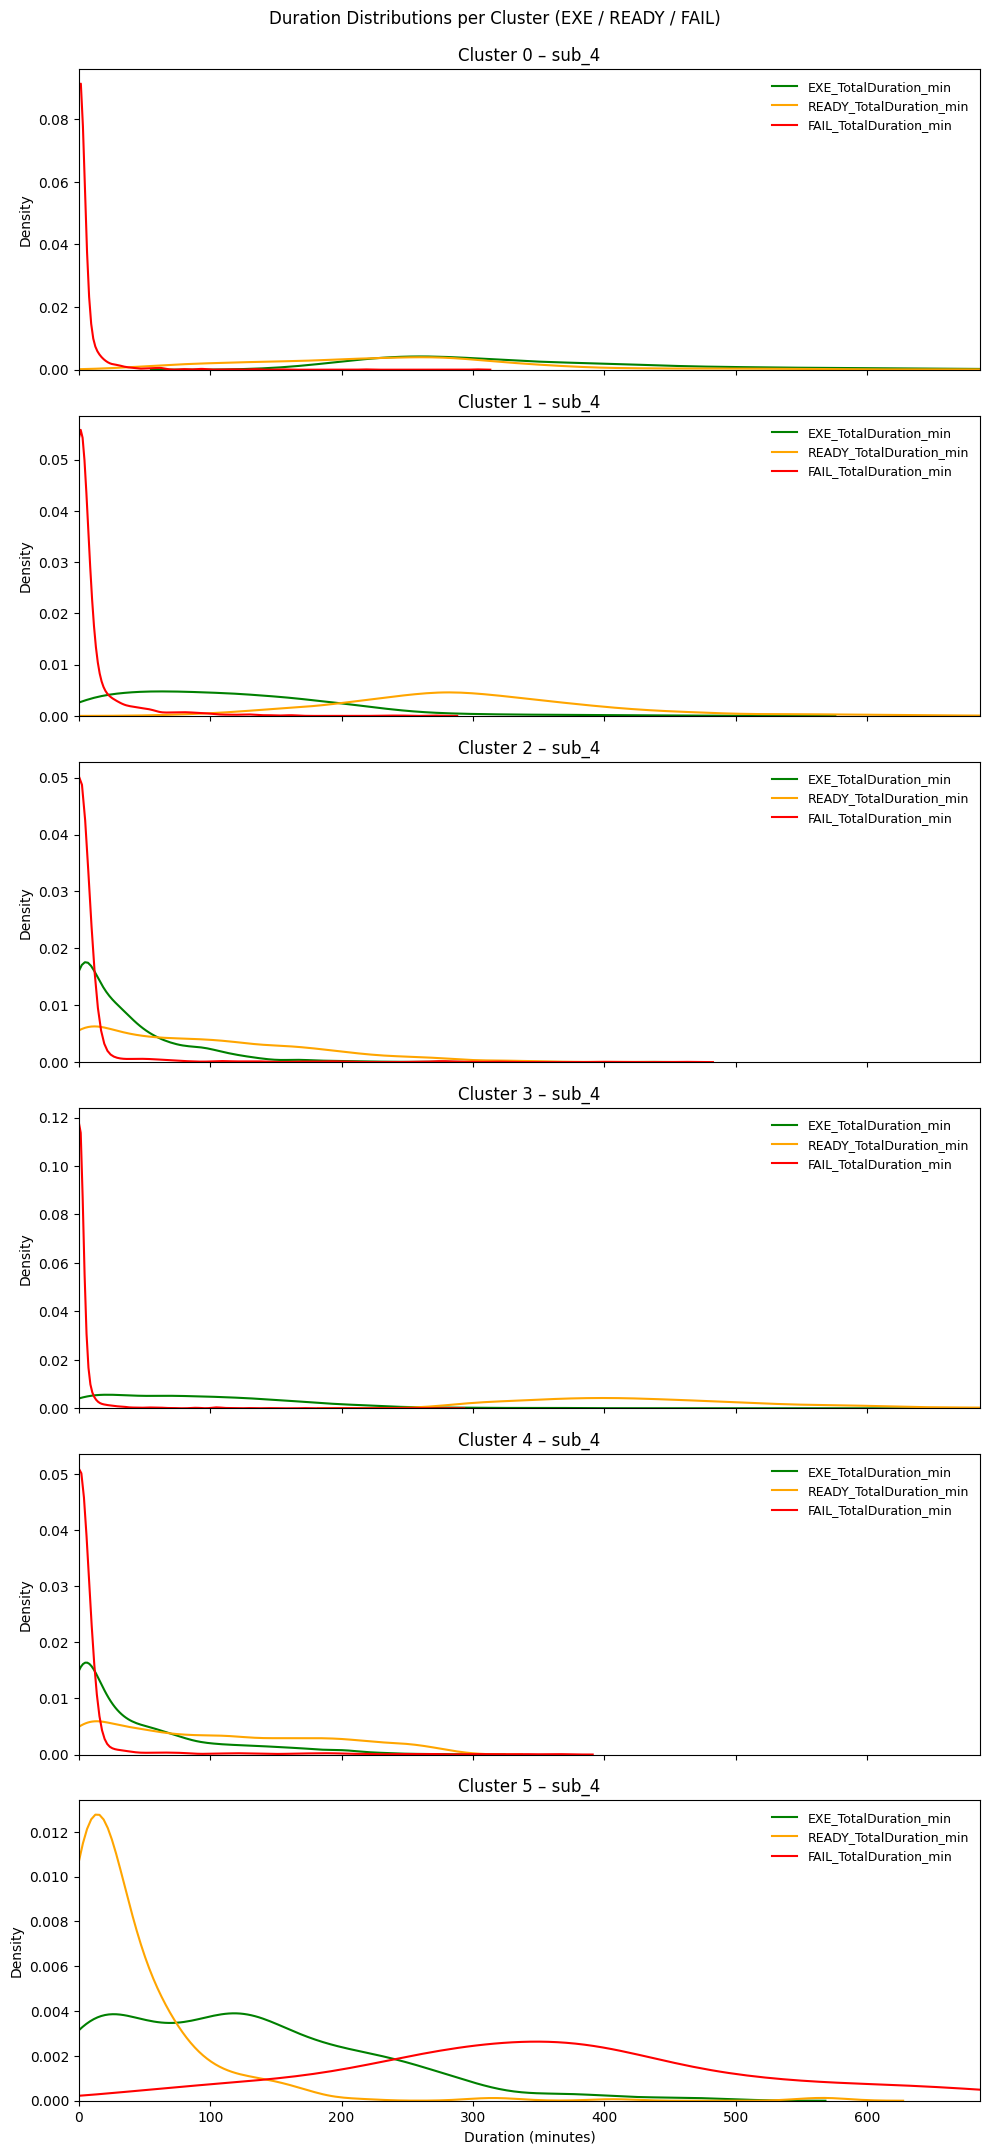

In [131]:
clustering('sub_4', 6)

## Labeling
The validated clusters formed the behavioral categories used as labels in the subsequent supervised classification phase.

In [132]:
labeled_sub_4 = pd.read_csv("clustering_output_kmeans/sub_4.csv")
cluster_label_map_sub_4 = {
    0: "Productive with Intermittent Idle Time",
    1: "Underutilized / Idle-Dominant",
    2: "Mostly Power-Off / Inactive",
    3: "Idle / Standby Machines",
    4: "Balanced Operation / Normal Activity",
    5: "High Failure Duration / Unstable"
}
labeled_sub_4['Cluster_Label'] = labeled_sub_4['KMeans_Cluster'].map(cluster_label_map_sub_4)
labeled_sub_4.drop(columns=['KMeans_Cluster'], inplace=True)
labeled_sub_4.to_csv("clustering_output_kmeans/sub_4_labeled.csv", index=False)

## 4-2- Clustering with *DBSAN* 
- The *DBSCAN* algorithm was also tested to validate cluster robustness and detect irregular or noisy behaviors.  
- While DBSCAN effectively identified sparse outlier points, these samples were too few and inconsistent to represent generalizable behavioral groups.  
- Moreover, since DBSCAN labels some points as noise (without assigning them to any cluster), its output was unsuitable for producing complete labels required for supervised classification.  
- In contrast, K-Means assigns every observation to a cluster, providing comprehensive and interpretable labeling for downstream modeling.  
- Therefore, K-Means was selected as the final clustering method.

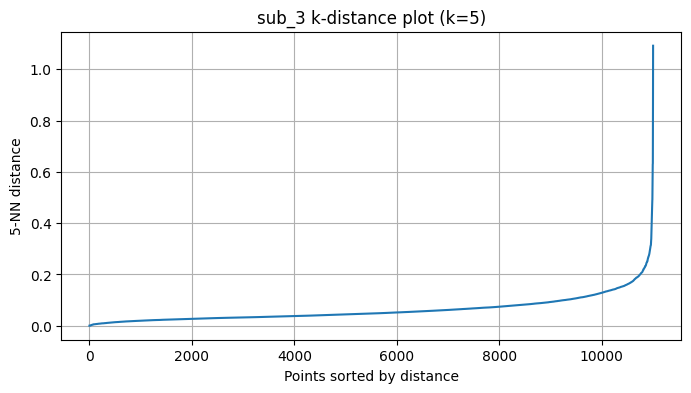

In [133]:
feature_cols = [
    'EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min',
    'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL',
    'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL',
    'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE',
    'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE',
    'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'
]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(sub_3_df[feature_cols])


def plot_k_distance(X, k=5, title="k-distance plot"):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    dists, _ = nn.kneighbors(X)
    kth = np.sort(dists[:, -1])
    plt.figure(figsize=(8,4))
    plt.plot(kth)
    plt.title(f"{title} (k={k})")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-NN distance")
    plt.grid(True)
    plt.show()
    return kth

plot_k_distance(X_scaled, k=5, title="sub_3 k-distance plot")

def clustering_dbscan(subtechnology_name, eps, min_samples=5, kdist_k=5, show_kdist=True):
    subtechnology_name = str(subtechnology_name)
    print(f"\nProcessing Subtechnology (DBSCAN): {subtechnology_name}\n")

    filtered_df = cleaned_df[cleaned_df['Subtechnology_Name_ITA'] == subtechnology_name].copy()
    if filtered_df.empty:
        raise ValueError(f"No rows found for {subtechnology_name}")

    initial_features = [
        'EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min',
        'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL',
        'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL',
        'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE',
        'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE',
        'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'
    ]
    print(f"Correlation matrix for {subtechnology_name} (scaled):\n")
    print(f"Initial features: {initial_features}")

    features_present = [c for c in initial_features if c in filtered_df.columns]
    if len(features_present) < 2: 
        raise ValueError("Not enough numeric features present for clustering.")

    scaler = MinMaxScaler()
    X_scaled_full = scaler.fit_transform(filtered_df[features_present])
    scaled_df = pd.DataFrame(X_scaled_full, columns=features_present, index=filtered_df.index)

    corr_matrix = scaled_df.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"Feature Correlation Heatmap for {subtechnology_name} (scaled)")
    plt.tight_layout(); plt.show()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.7)]
    reduced_features = [c for c in features_present if c not in to_drop]
    if len(reduced_features) < 2:
        reduced_features = features_present

    print(f"Highly correlated features to drop (|corr| > 0.7): {to_drop}")
    print(f"Reduced features: {reduced_features} (n={len(reduced_features)})\n")

    updated_corr_matrix = scaled_df[reduced_features].corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(updated_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"Correlation After Pruning • {subtechnology_name} (scaled)")
    plt.tight_layout(); plt.show()

    X_scaled = scaled_df[reduced_features].values

    if show_kdist:
        plot_k_distance(X_scaled, k=kdist_k, title=f"{subtechnology_name} k-distance")

    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=None)
    labels = db.fit_predict(X_scaled)
    filtered_df['DBSCAN_Cluster'] = labels

    n_noise = int(np.sum(labels == -1))
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"DBSCAN results → clusters: {n_clusters}, noise points: {n_noise}")

    valid_mask = labels != -1
    unique_valid = np.unique(labels[valid_mask])
    if len(unique_valid) >= 2 and np.all(np.bincount(labels[valid_mask] - labels[valid_mask].min()) > 1):
        sil = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
        print(f"Silhouette score (excluding noise): {sil:.3f}")
    else:
        print("Silhouette score not computed (need ≥2 non-noise clusters with >1 sample each).")

    if len(reduced_features) >= 3:
        pca = PCA(n_components=3, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        unique_labels = np.unique(labels)
        cluster_labels = [lab for lab in unique_labels if lab != -1]
        n_clusters = len(cluster_labels)
        
        palette = plt.cm.get_cmap('tab20', max(n_clusters, 1))
        gray_rgba = mcolors.to_rgba('#808080')
        
        label2color = {-1: gray_rgba}
        for idx, lab in enumerate(cluster_labels):
            label2color[lab] = palette(idx)
        
        point_colors = [label2color[lab] for lab in labels]
        
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                   c=point_colors, alpha=0.65, s=18, edgecolors='none')
        ax.set_title(f"DBSCAN (eps={eps}, min_samples={min_samples}) • PCA(3) • {subtechnology_name}")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        plt.show()

    def minutes_to_hms(x):
        return str(datetime.timedelta(seconds=int(x * 60))) if pd.notnull(x) else None

    all_duration_cols = ["EXE_TotalDuration_min", "FAIL_TotalDuration_min",
                         "READY_TotalDuration_min", "POWER_OFF_TotalDuration_min"]

    cluster_means = filtered_df.groupby('DBSCAN_Cluster')[reduced_features].mean()
    cluster_counts = filtered_df['DBSCAN_Cluster'].value_counts()
    distinct_serial_counts = filtered_df.groupby('DBSCAN_Cluster')['Serial Number'].nunique()

    cluster_means['Total_Count'] = cluster_counts
    cluster_means['Distinct_Serials'] = distinct_serial_counts
    cluster_means = cluster_means.sort_index()
    cluster_means_formatted = cluster_means.copy()

    for col in all_duration_cols:
        if col in cluster_means_formatted.columns:
            cluster_means_formatted[col] = cluster_means_formatted[col].apply(minutes_to_hms)

    cols = ['Total_Count', 'Distinct_Serials'] + \
           [c for c in cluster_means_formatted.columns if c not in ['Total_Count', 'Distinct_Serials']]
    cluster_means_formatted = cluster_means_formatted[cols]

    available_duration_cols = [c for c in all_duration_cols if c in filtered_df.columns]
    if available_duration_cols:
        desc_df = filtered_df[available_duration_cols].describe()
        desc_formatted = pd.DataFrame(index=desc_df.index, columns=desc_df.columns, dtype='object')
        for row in desc_df.index:
            if row == 'count':
                desc_formatted.loc[row] = desc_df.loc[row]
            else:
                desc_formatted.loc[row] = desc_df.loc[row].map(lambda x: minutes_to_hms(x) if pd.notnull(x) else None)
    else:
        desc_formatted = pd.DataFrame()

    print(f"\nSubtechnology: {subtechnology_name}")
    print(f"Number of records: {filtered_df.shape[0]}")
    print("\nCluster Statistics Summary (minutes → hh:mm:ss):")
    if not desc_formatted.empty:
        print(desc_formatted.to_string())
    print("\nCluster means:")
    print(cluster_means_formatted.to_string())
    print("___" * 80)
    print("___" * 80)
    print("\n")


    for cl in sorted(filtered_df['DBSCAN_Cluster'].dropna().unique()):
        print(f"\n--- Cluster {int(cl)} ---")
        cdf = filtered_df[filtered_df['DBSCAN_Cluster'] == cl]
        if available_duration_cols:
            dsc = cdf[available_duration_cols].describe()
            dsc_fmt = pd.DataFrame(index=dsc.index, columns=dsc.columns, dtype='object')
            for row in dsc.index:
                if row == 'count':
                    dsc_fmt.loc[row] = dsc.loc[row]
                else:
                    dsc_fmt.loc[row] = dsc.loc[row].map(lambda x: minutes_to_hms(x) if pd.notnull(x) else None)
            print(dsc_fmt.to_string())
        else:
            print("No duration columns to summarize.")


    duration_cols = ["EXE_TotalDuration_min", "READY_TotalDuration_min", "FAIL_TotalDuration_min"]
    color_map = {
        "EXE_TotalDuration_min": "green",
        "READY_TotalDuration_min": "orange",
        "FAIL_TotalDuration_min": "red",
    }
    
    clusters = sorted(filtered_df['DBSCAN_Cluster'].dropna().unique())
    
    def robust_max(series):
        if len(series) == 0:
            return 0.0
        return np.nanpercentile(series, 99.5)
    
    global_xmax = 0.0
    for f in duration_cols:
        if f in filtered_df.columns:
            global_xmax = max(global_xmax, robust_max(filtered_df[f].values))
    
    if not np.isfinite(global_xmax) or global_xmax <= 0:
        global_xmax = 1.0
    
    xlim = (0, float(global_xmax) * 1.05)
    
    total_plots = len(clusters)
    fig, axes = plt.subplots(
        nrows=total_plots, ncols=1, figsize=(10, 3.6 * total_plots), sharex=True
    )
    
    if total_plots == 1:
        axes = [axes]
    
    for i, cl in enumerate(clusters):
        ax = axes[i]
        cdata = filtered_df[filtered_df['DBSCAN_Cluster'] == cl]
    
        for f in duration_cols:
            if f not in cdata.columns:
                continue
            col = cdata[f].dropna()
    
            can_kde = (len(col) >= 3) and (col.nunique() >= 2)
    
            if can_kde:
                sns.kdeplot(
                    x=col,
                    ax=ax,
                    label=f,
                    clip=(0, None),
                    bw_adjust=1.0,
                    common_norm=False,
                )
            else:
                sns.histplot(
                    x=col,
                    ax=ax,
                    label=f,
                    stat="density",
                    element="step",
                    fill=False,
                    bins=30
                )
    
        title_suffix = " (noise)" if cl == -1 else ""
        ax.set_title(f"DBSCAN Cluster {int(cl)}{title_suffix} – {subtechnology_name}")
        ax.set_xlim(xlim)
        ax.set_xlabel("Duration (minutes)")
        ax.set_ylabel("Density")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    os.makedirs("clustering_output_dbscan", exist_ok=True)
    cols_to_save = reduced_features + ["DBSCAN_Cluster", "Serial Number", "Date", "Subtechnology_Name_ITA"]
    filtered_df[cols_to_save].to_csv(f"clustering_output_dbscan/{subtechnology_name}.csv", index=False)
    print(f"Saved: clustering_output_dbscan/{subtechnology_name}.csv")


Processing Subtechnology (DBSCAN): sub_3

Correlation matrix for sub_3 (scaled):

Initial features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']


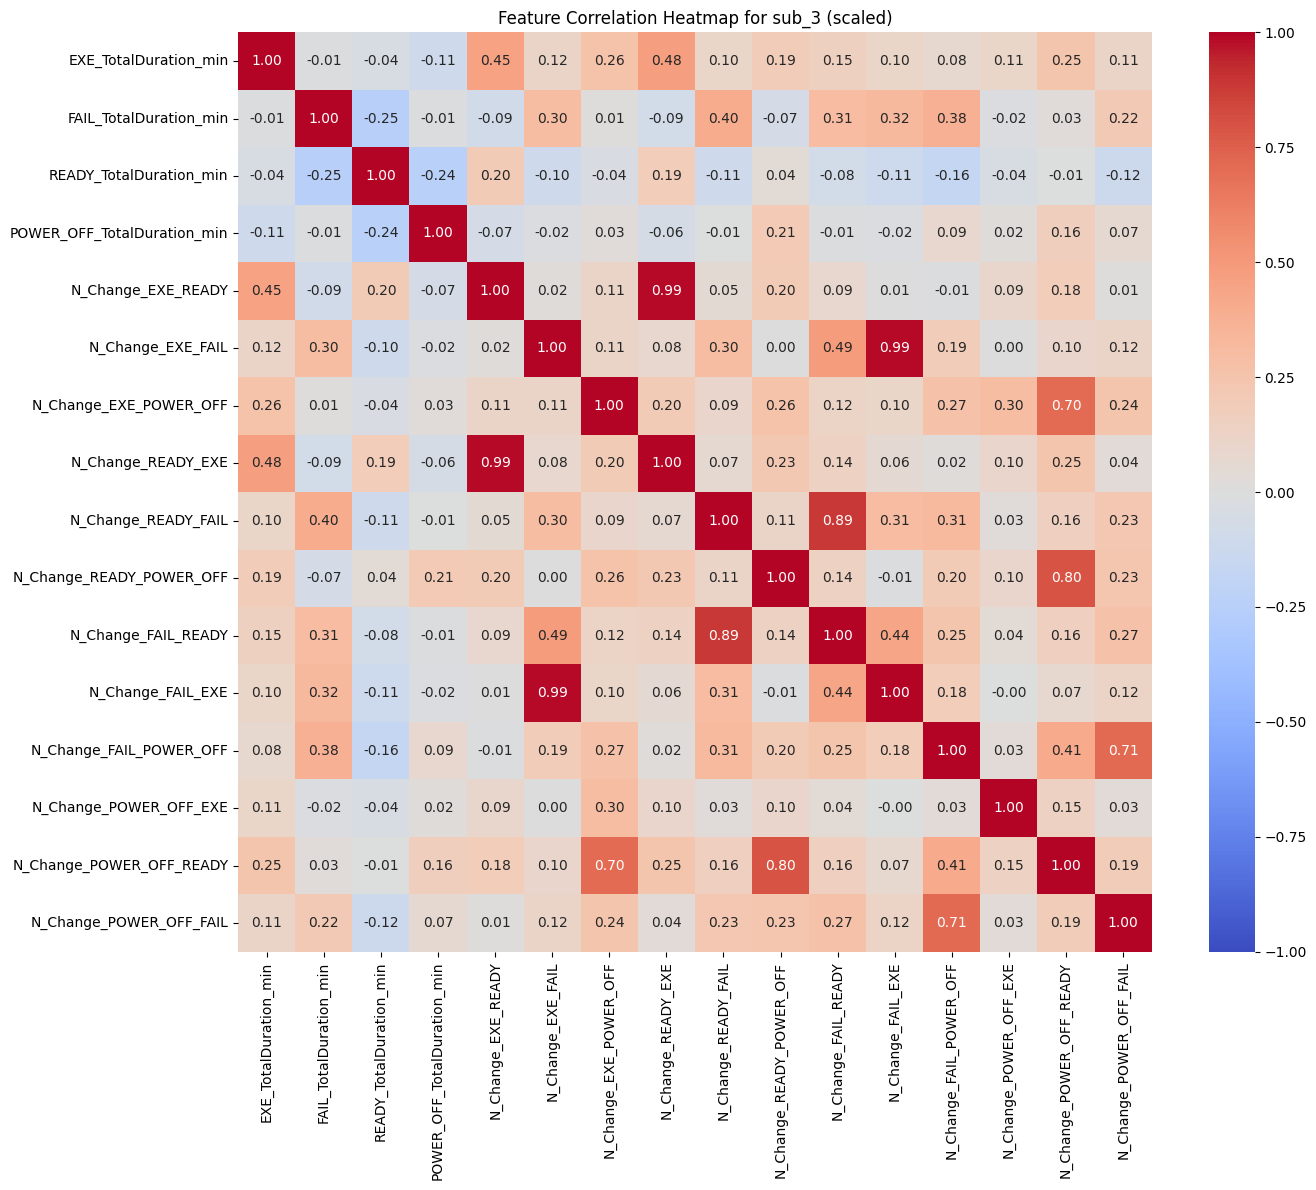

Highly correlated features to drop (|corr| > 0.7): ['N_Change_READY_EXE', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']
Reduced features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE'] (n=11)



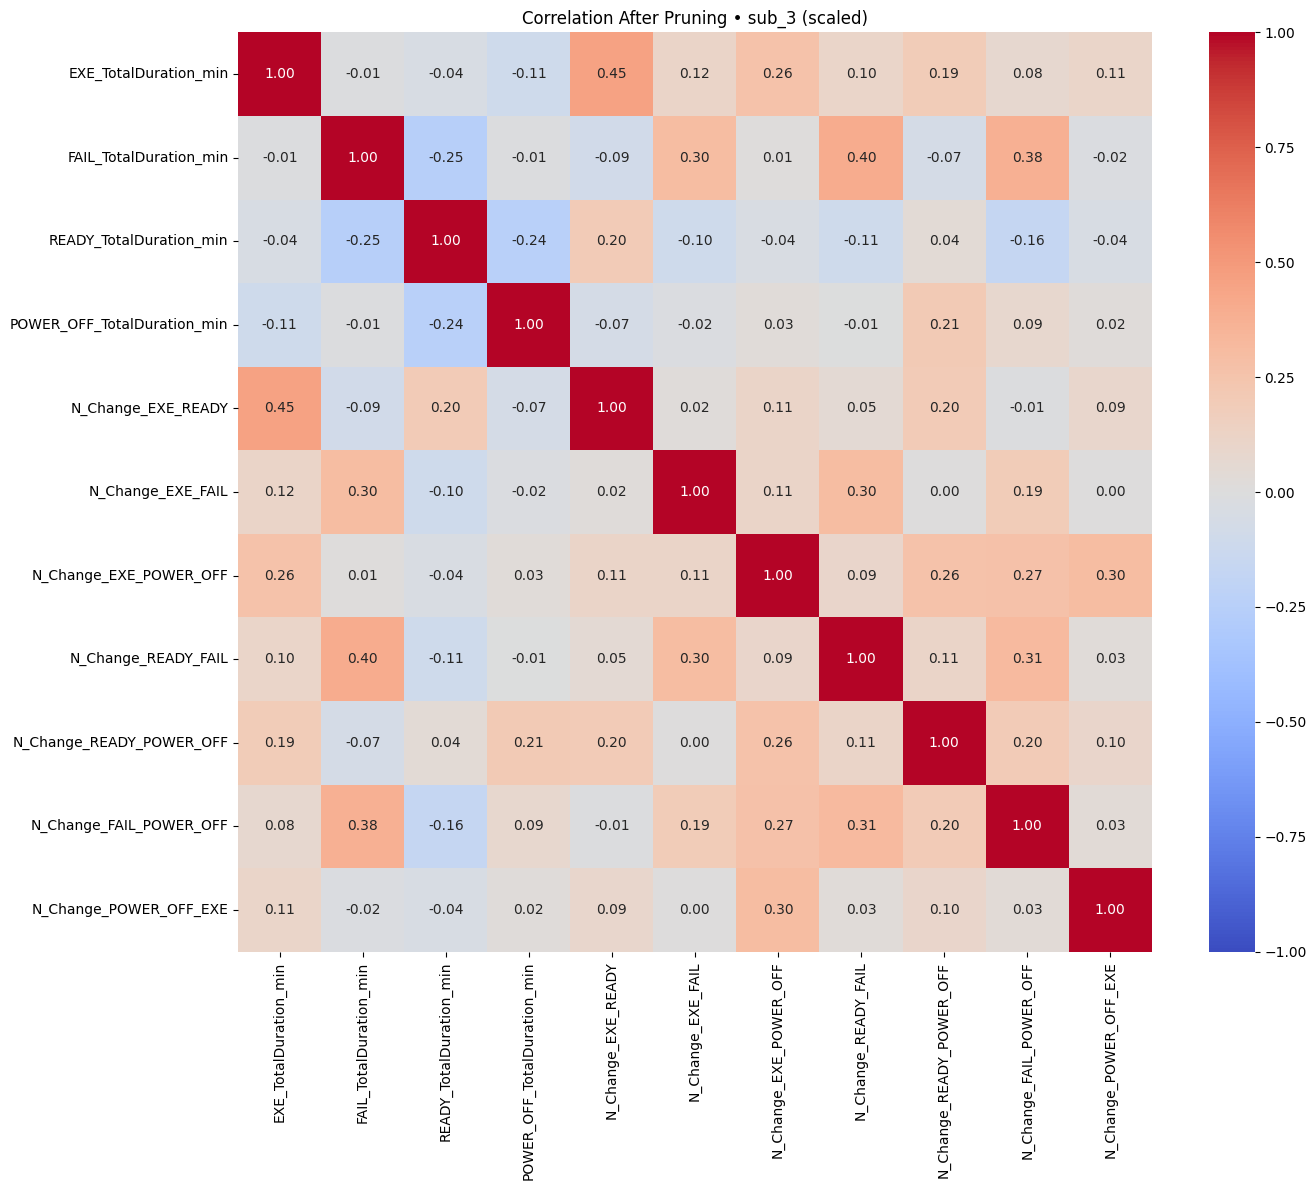

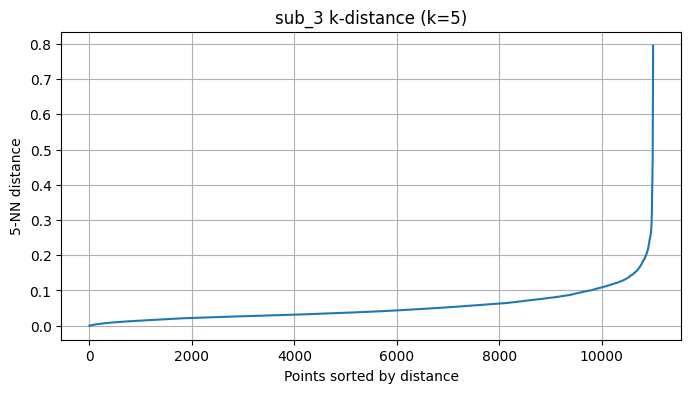

DBSCAN results → clusters: 8, noise points: 212
Silhouette score (excluding noise): 0.315


/var/folders/57/_z35wjvj6399htfh41br6l1r0000gn/T/ipykernel_89820/2694108299.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', max(n_clusters, 1))


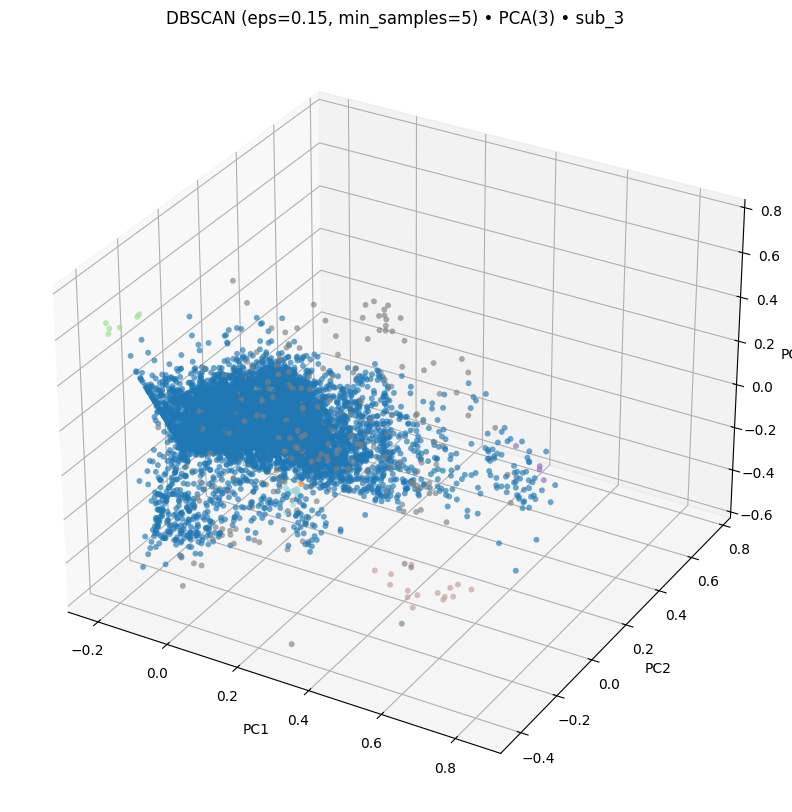


Subtechnology: sub_3
Number of records: 11003

Cluster Statistics Summary (minutes → hh:mm:ss):
      EXE_TotalDuration_min FAIL_TotalDuration_min READY_TotalDuration_min POWER_OFF_TotalDuration_min
count              11003.00               11003.00                11003.00                    11003.00
mean                2:41:36                0:16:39                 4:14:03                     0:59:02
std                 2:51:29                1:03:42                 2:43:09                     1:49:41
min                 0:00:00                0:00:00                 0:00:00                     0:00:00
25%                 0:35:00                0:00:00                 2:04:00                     0:01:00
50%                 1:53:00                0:00:00                 4:09:00                     0:13:00
75%                 3:52:00                0:02:00                 6:10:00                     1:09:00
max                21:23:00               13:26:00                21:40:00     

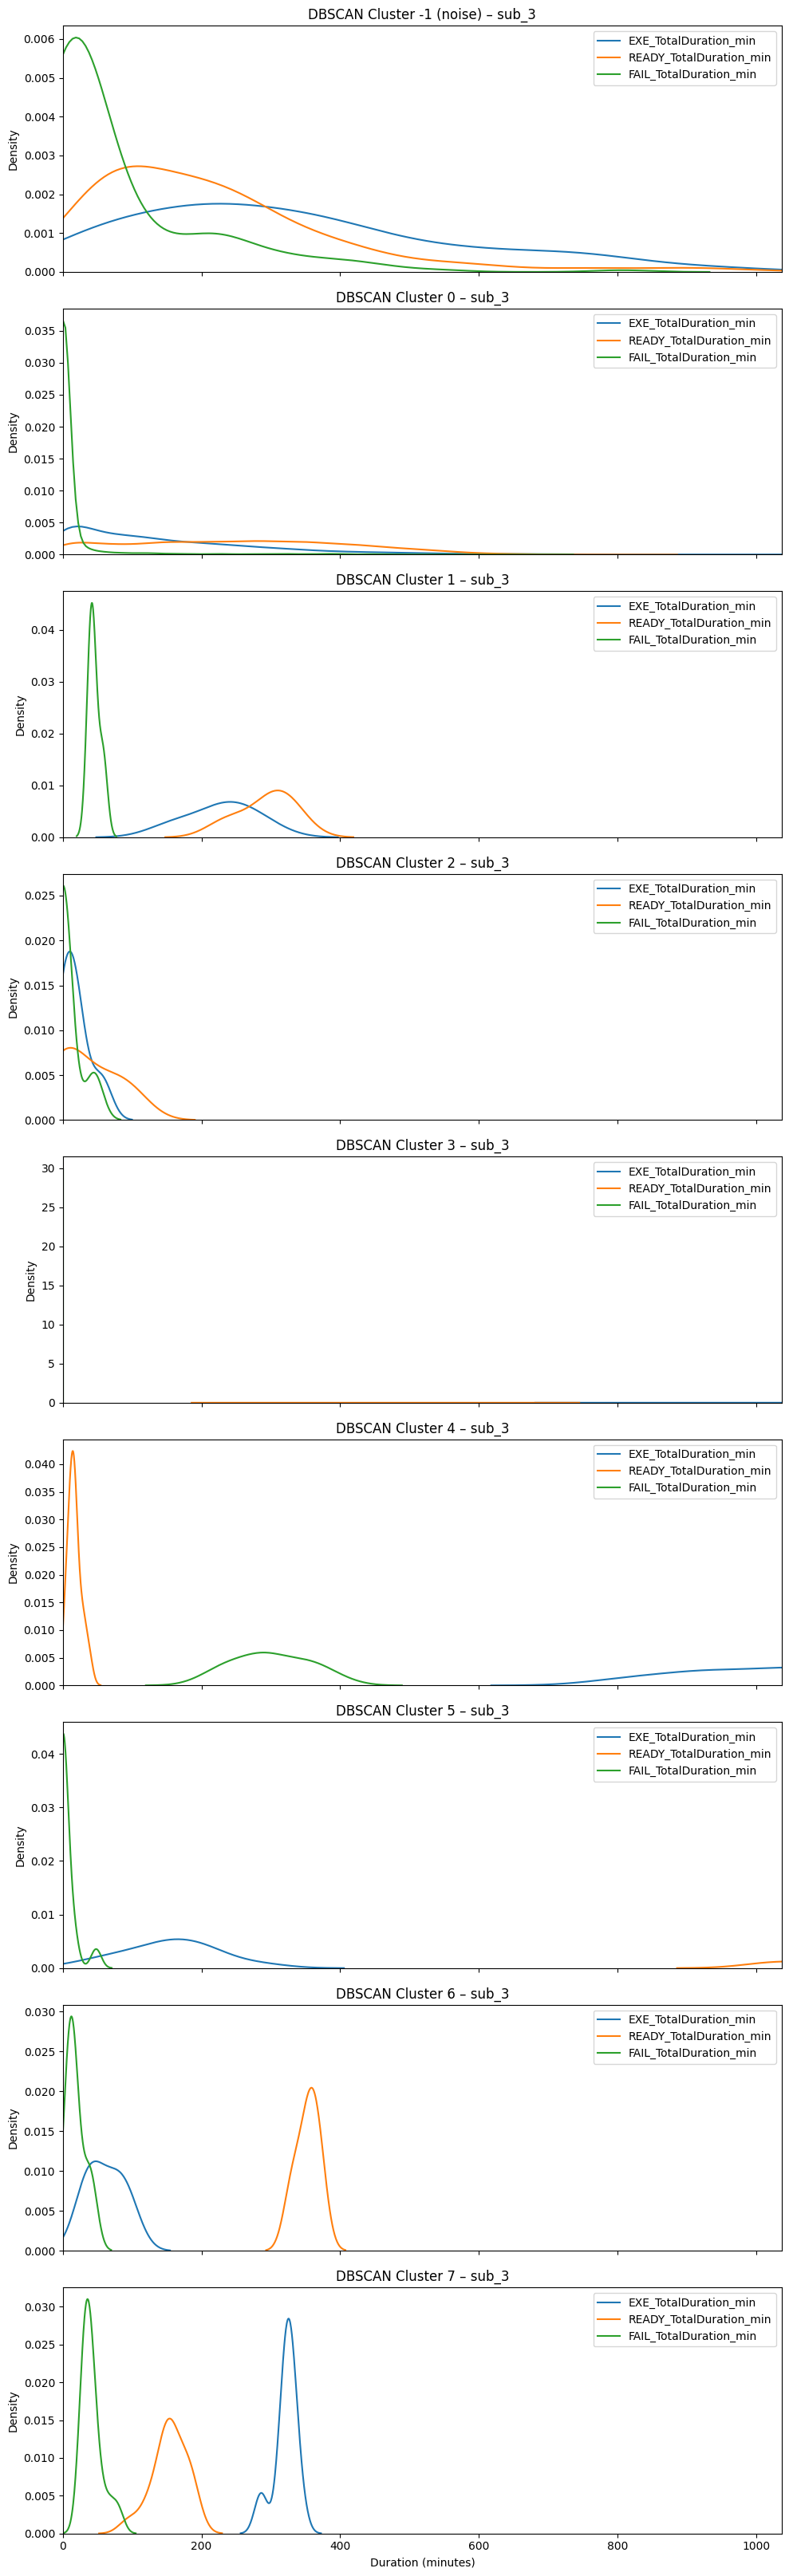

Saved: clustering_output_dbscan/sub_3.csv


In [134]:
clustering_dbscan("sub_3", eps=0.15, min_samples=5, kdist_k=5, show_kdist=True)



Processing Subtechnology (DBSCAN): sub_4

Correlation matrix for sub_4 (scaled):

Initial features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']


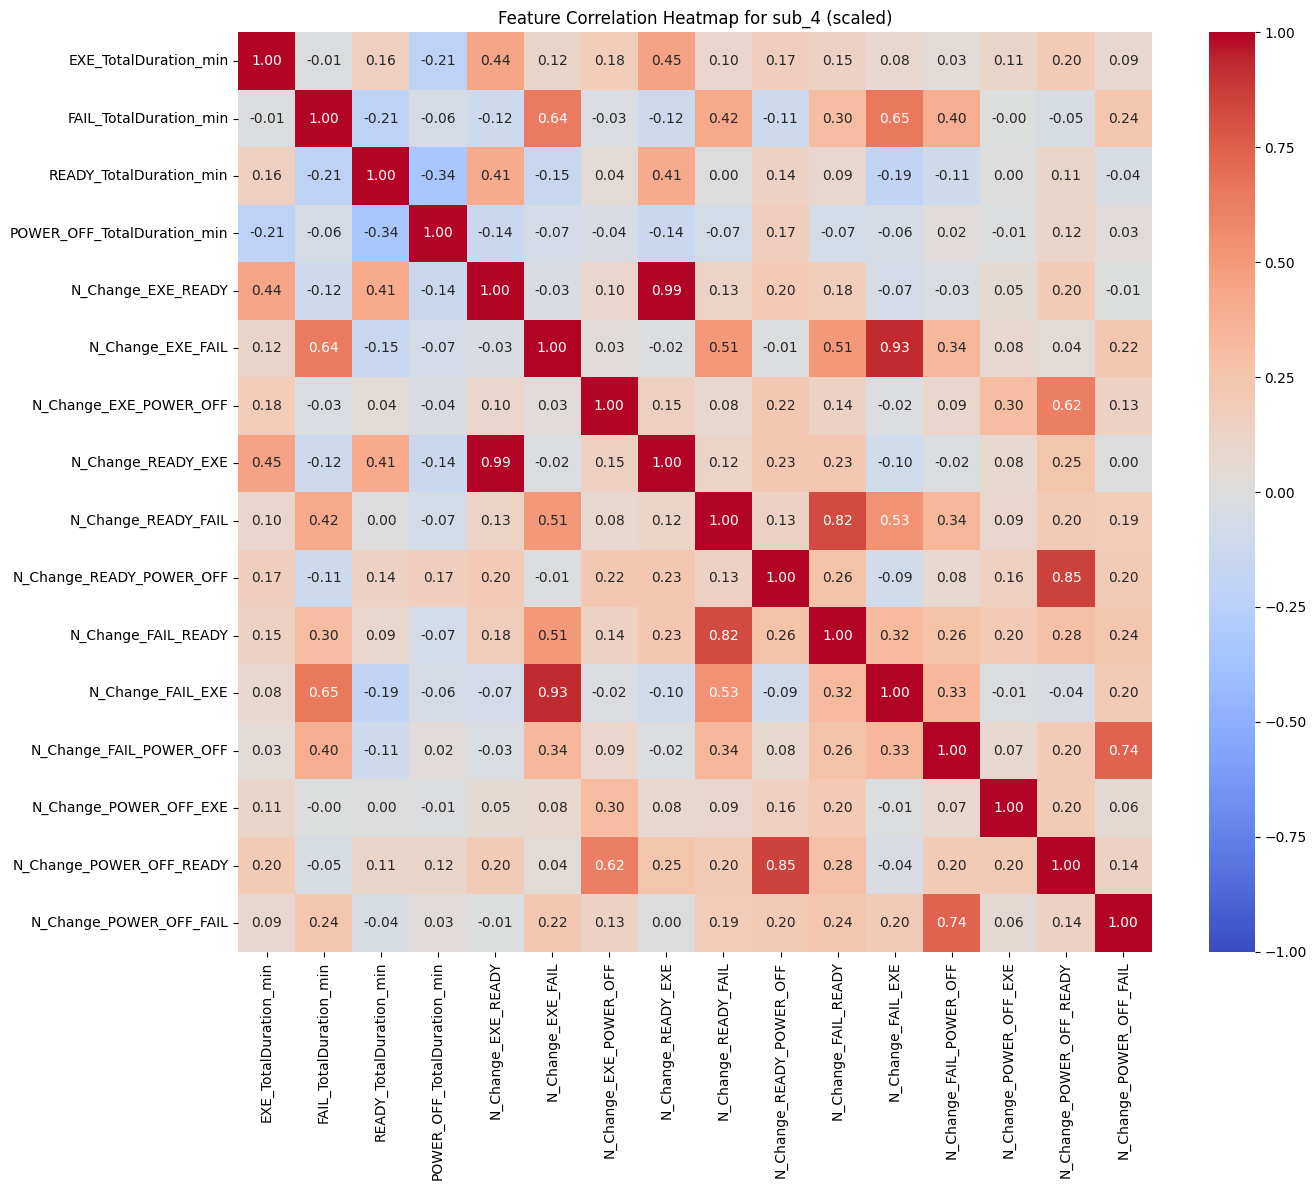

Highly correlated features to drop (|corr| > 0.7): ['N_Change_READY_EXE', 'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL']
Reduced features: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE'] (n=11)



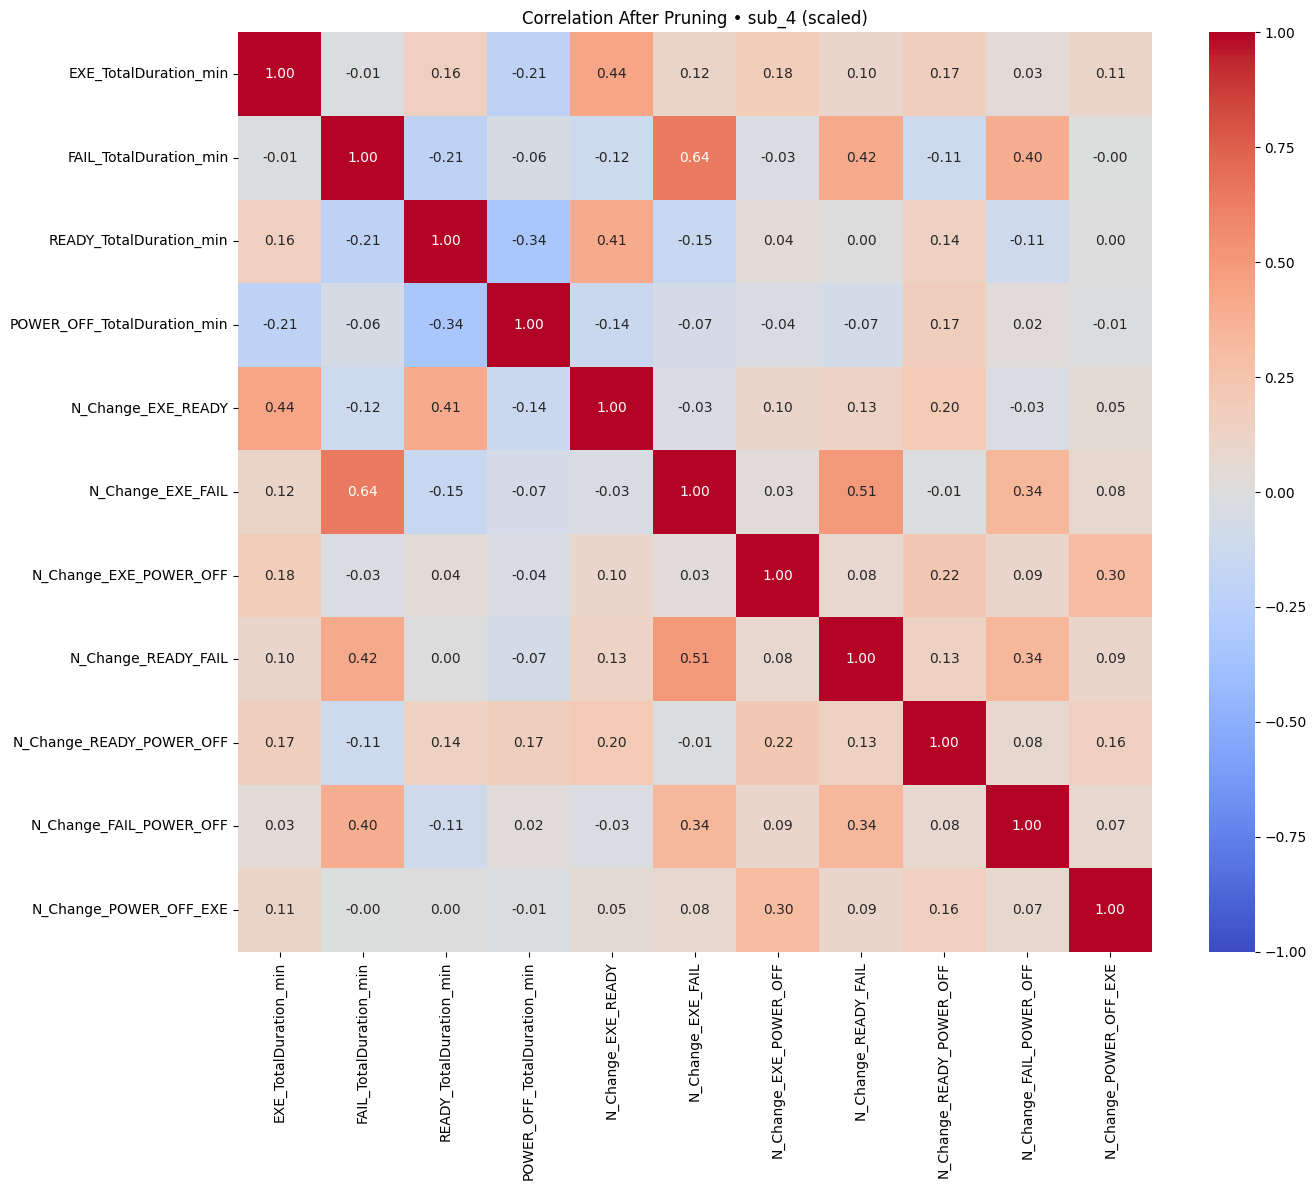

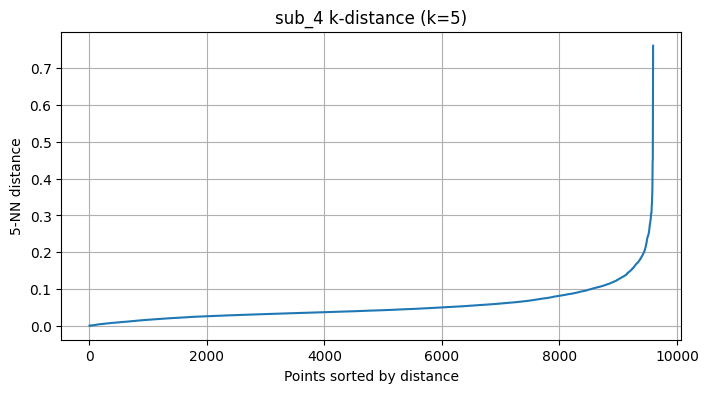

DBSCAN results → clusters: 4, noise points: 91
Silhouette score (excluding noise): 0.582


/var/folders/57/_z35wjvj6399htfh41br6l1r0000gn/T/ipykernel_89820/2694108299.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', max(n_clusters, 1))


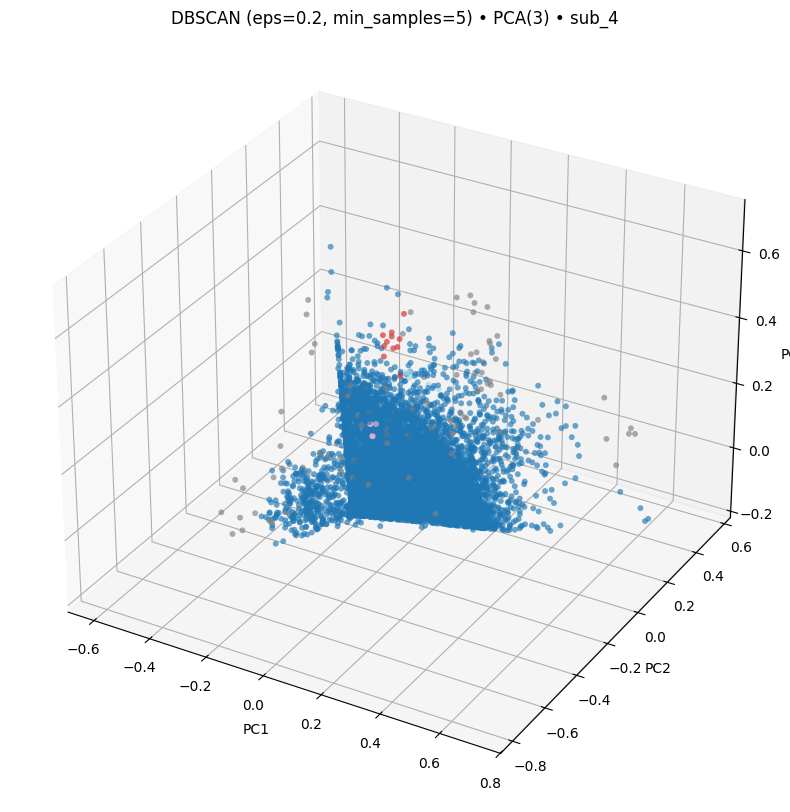


Subtechnology: sub_4
Number of records: 9596

Cluster Statistics Summary (minutes → hh:mm:ss):
      EXE_TotalDuration_min FAIL_TotalDuration_min READY_TotalDuration_min POWER_OFF_TotalDuration_min
count               9596.00                9596.00                 9596.00                     9596.00
mean                1:53:17                0:18:58                 4:08:47                     1:41:53
std                 2:11:20                1:21:38                 2:58:37                     2:24:44
min                 0:00:00                0:00:00                 0:00:00                     0:00:00
25%                 0:19:00                0:00:00                 1:32:00                     0:03:00
50%                 1:11:00                0:00:00                 3:57:30                     0:39:00
75%                 2:43:15                0:02:00                 6:19:00                     2:19:00
max                22:36:00               20:02:00                21:59:00      

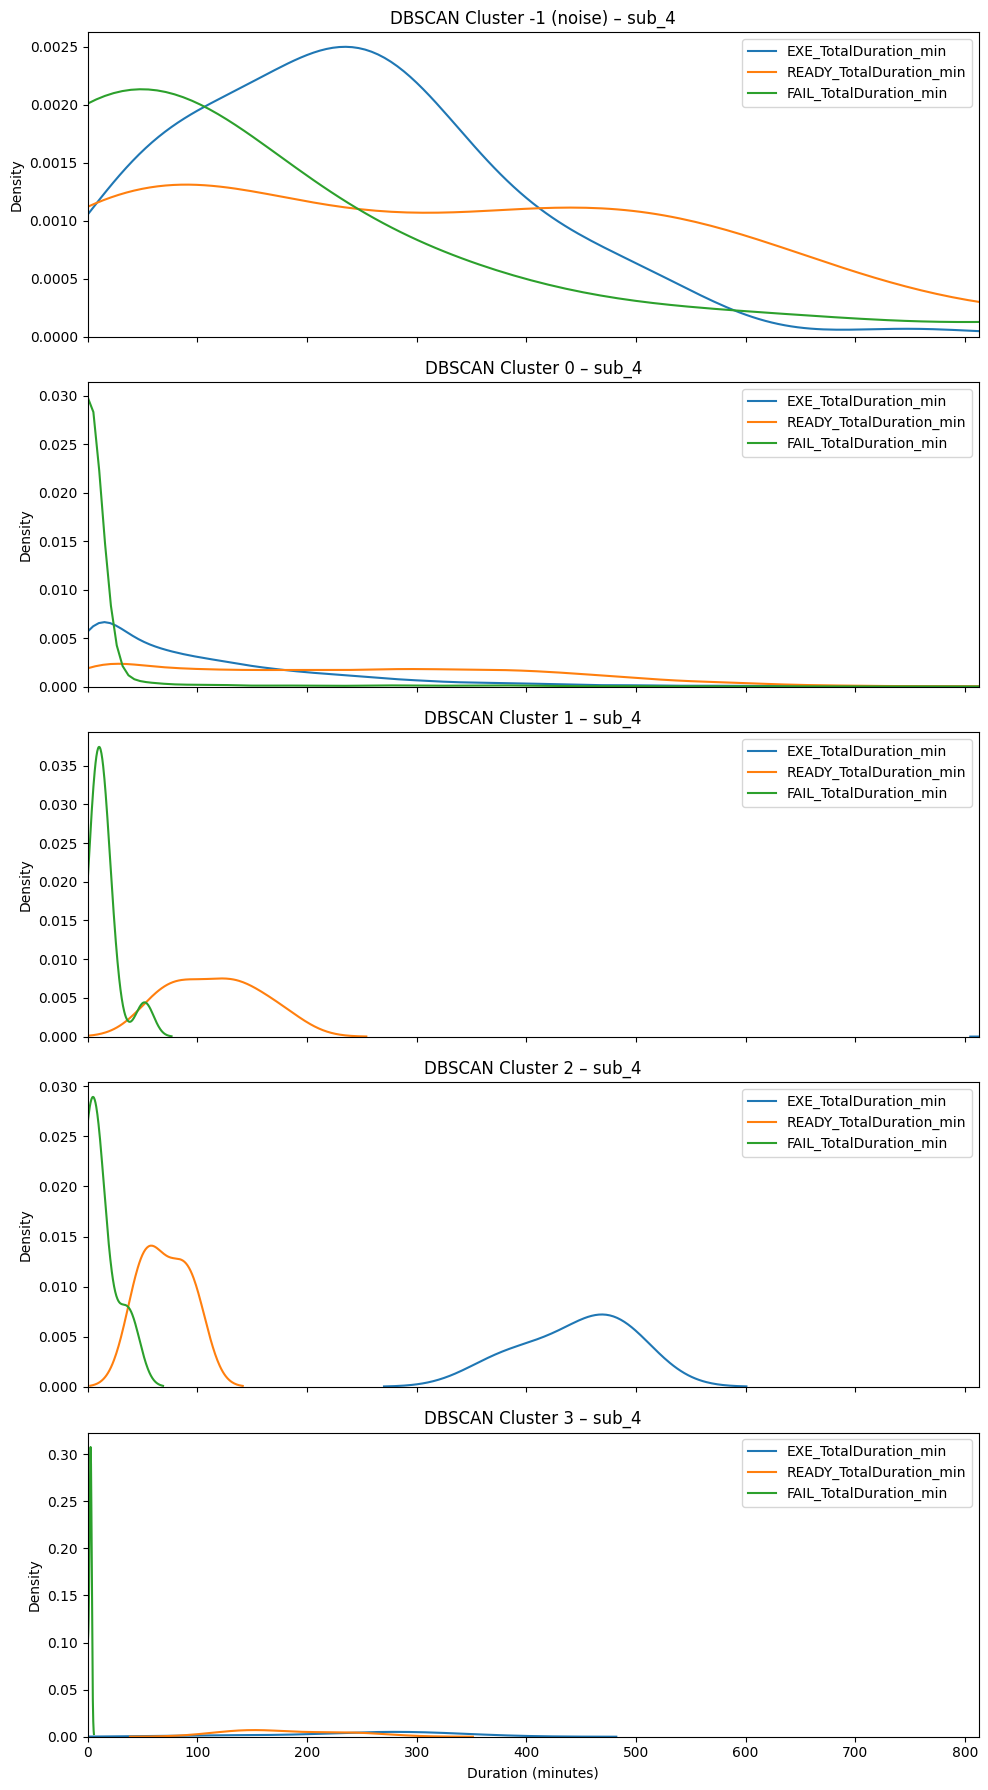

Saved: clustering_output_dbscan/sub_4.csv


In [135]:
clustering_dbscan("sub_4", eps=0.2, min_samples=5, kdist_k=5, show_kdist=True)
